# Figure 5. Global effect of SRSF3
---

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-11-30.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
utilpath = '/casa/bsc/notebooks/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append(utilpath)
from util import *
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/201130/


In [111]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st
from matplotlib import pyplot as plt
from matplotlib import lines, gridspec, colors
from collections import defaultdict, Counter
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import sem, ttest_ind, mannwhitneyu, spearmanr, pearsonr
from scipy import stats as st
from sequtil import nmer
import statsmodels.api as sm
%matplotlib inline

In [5]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

In [6]:
s1 = pd.read_csv('supplementary/201123_s1__DROSHA_dependency.csv', header=1, index_col=0)
s2 = pd.read_csv('supplementary/201123_s2__Construct.csv', header=1, index_col=0).fillna('')
s3 = pd.read_csv('supplementary/201123_s3__DROSHA_processing_result.csv', header=1, index_col=0)
s4 = pd.read_csv('supplementary/201123_s4__MiRNA_features.csv', header=1, index_col=0)
s5 = pd.read_csv('supplementary/201123_s5__Nick_processing.csv', header=1, index_col=0)
s6 = pd.read_csv('supplementary/201123_s6__Inverted_processing.csv', header=1, index_col=0)
s7 = pd.read_csv('supplementary/201123_s7__DROSHA_processing_with_SRSF3.csv',
                 header=1, index_col=0)

In [7]:
preposition = {}
for mir in s2.index:
    flank5, flank3 = s2.loc[mir,["5' flanking segment","3' flanking segment"]]
    if flank5 or flank3:
        preposition[mir] = (len(flank5)+1,125-len(flank3))
    else:
        preposition[mir] = (0,126)
print len(preposition), preposition['hsa-mir-142']

1881 (32, 90)


In [8]:
drodep = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-dependent')>=0)].index
droind = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-independent')>=0)].index
droko = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA KO')>=0)].index
fclip = s1[s1['DROSHA dependency'].apply(lambda x:x.find('fCLIP')>=0)].index
dbmirs = s1[s1['MirGeneDB']=='Annotated'].index
print len(drodep), len(droind), len(droko), len(fclip), len(dbmirs)

304 257 157 281 503


In [9]:
constseqs = dict(s2['Construct sequence (125 nt)'])
print len(constseqs)

1881


In [18]:
EFFCUT = 2.5
HOMCUT = .25
effsmp = s3['Cleavage Efficiency'].to_dict()
homsmp = s3['Cleavage Homogeneity'].to_dict()
dcsmirsmp = [ m for m in s3.index if effsmp[m]>=EFFCUT and homsmp[m]>=HOMCUT ]
nodcsmp = [ m for m in s3.index if m not in dcsmirsmp ]
print len(s3.index), len(dcsmirsmp), len(nodcsmp)

1816 534 1282


In [19]:
effs = s7['Cleavage Efficiency'].to_dict()
homs = s7['Cleavage Homogeneity'].to_dict()
dcsmirs = [ m for m in s7.index if effs[m]>=EFFCUT and homs[m]>=HOMCUT ]
nodcs = [ m for m in s7.index if m not in dcsmirs ]
print len(s7.index), len(dcsmirs), len(nodcs)

1812 749 1063


In [205]:
s7[s7['Cleavage ratio of alternative site']>=.25]

,Cleavage Efficiency,Cleavage Homogeneity,5' miRBase site,3' miRBase site,5' cleavage site,3' cleavage site,5' alternative site,3' alternative site,Cleavage ratio of alternative site,5p nick processing,3p nick processing,Inverted processing
Pri-miRNA,,,,,,,,,,,,
hsa-mir-101-2,11.146716,0.486255,32,88,32.0,88.0,31.0,89.0,0.418423,0.680473,0.112426,0.002959
hsa-mir-105-1,9.118391,0.403809,32,91,35.0,88.0,32.0,90.0,0.311059,0.277573,0.025005,0.003489
hsa-mir-1267,10.286651,0.538567,35,88,36.0,87.0,35.0,88.0,0.277677,0.010039,0.005625,0.031415
hsa-mir-1284,8.749062,0.461223,31,92,32.0,91.0,31.0,92.0,0.351590,0.212996,0.379061,0.003610
hsa-mir-1285-1,8.468313,0.288089,31,91,32.0,91.0,31.0,92.0,0.284421,0.001883,0.001674,0.021339
hsa-mir-1303,14.053040,0.397783,31,90,31.0,90.0,32.0,89.0,0.272460,0.001192,0.017878,0.005959
hsa-mir-1305,9.533964,0.404525,32,89,32.0,89.0,30.0,91.0,0.334187,0.006868,0.020147,0.001374
hsa-mir-152,10.100217,0.420164,32,90,31.0,91.0,32.0,90.0,0.368831,0.003660,0.000915,0.015006
hsa-mir-2681,10.878789,0.529542,31,91,31.0,91.0,32.0,90.0,0.285007,0.000997,0.017942,0.458261


---

## A. Global change induced by SRSF3

In [16]:
def get_2d_density(data, xmin, xmax, ymin, ymax):
    x, y = zip(*data)
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return xx, yy, f

In [25]:
overlap = [ m for m in effs if m in effsmp ]
data1 = [ (effsmp[m],homsmp[m]) for m in overlap ]
data2 = [ (effs[m],homs[m]) for m in overlap ]
xmin, xmax = -3, 14
ymin, ymax = -.25, 1.1
xs1,ys1,f1 = get_2d_density(data1, xmin, xmax, ymin, ymax)
xs2,ys2,f2 = get_2d_density(data2, xmin, xmax, ymin, ymax)
blk = custom_cmap(['white','black'])
red = custom_cmap(['white','#de2d26'])
print len(overlap)

1800


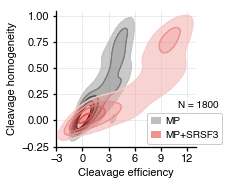

In [357]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.contourf(xs1,ys1,f1,levels=[.05,.15,.3,.6,.99],cmap=blk,alpha=.5,
            norm=colors.LogNorm(vmin=0.02, vmax=1),zorder=3)
ax.contour(xs1,ys1,f1,levels=[.05,.15,.3,.6,.99],cmap=blk,linestyles='-',linewidths=1.3,
          norm=colors.LogNorm(vmin=0.02, vmax=1),zorder=3)
ax.contourf(xs2,ys2,f2,levels=[.05,.15,.3,.6,.99],cmap=red,alpha=.5,
            norm=colors.LogNorm(vmin=0.02, vmax=1),zorder=3)
ax.contour(xs2,ys2,f2,levels=[.05,.15,.3,.6,.99],cmap=red,linestyles='-',linewidths=1.3,
          norm=colors.LogNorm(vmin=0.02, vmax=1), zorder=3)

ax.set_xticks(range(-3,13,3))
ax.set_yticks(np.arange(-.25,1.1,.25))
ax.set_xlim(-3,13)
ax.set_ylim(-.25,1.05)
ax.set_xlabel('Cleavage efficiency', fontsize=11)
ax.set_ylabel('Cleavage homogeneity', fontsize=11)
ax.bar([-10],[0],color='grey',label='MP',alpha=.5)
ax.bar([-10],[0],color='#de2d26',label='MP+SRSF3',alpha=.5)
ax.grid(ls='-',lw=.5)
ax.legend(loc=(.65,.02),handlelength=1,framealpha=1,handletextpad=.4)
ax.text(11,.12,'N = %s'%len(overlap))
fig.savefig(resultpath+'201118_f5a__global_change_v2.pdf')

## S1A-B. Homogeneity & Efficiency

In [73]:
mirls = [ [m for m in s7.index if m in drodep], 
          [m for m in s7.index if m in droind],
          [m for m in s7.index if m not in list(drodep)+list(droind)] ]
xsl = [ [effs[m] for m in ml] for ml in mirls ]
ysl = [ [homs[m] for m in ml] for ml in mirls ]
fcolors = [ '#80b1d3', '#666666', '#cbcbcb' ]
ecolors = [ '#386cb0', '#252525','#bababa' ]
labels = [ 'DROSHA-dep.', 'DROSHA-ind.', 'All' ]
sizes = [ 10, 10, 6 ]
zs = [ 3, 3, 2 ]
xmin, xmax, xo = 0, 13, .3
ymin, ymax, yo = 0, 1, .03
xcut, ycut = 2.5, .25
shade = '#a1d99b'

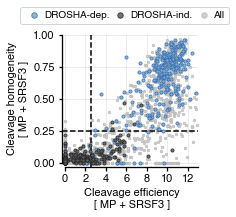

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
for xs,ys,fc,ec,label,s,z in zip(xsl,ysl,fcolors,ecolors,labels,sizes,zs):
    xs,ys = zip(*[ (x,y) for x,y in zip(xs,ys) if xmin<=x<xmax and ymin<=y<ymax])
    ax.scatter(xs, ys, s=s, color=fc, edgecolor=ec, lw=.8, zorder=z, label=label, alpha=.9,
              rasterized=True)
ax.plot([xmin-xo,xmax],[ycut,ycut],'k--',zorder=2)
ax.plot([xcut,xcut],[ymin-yo,ymax],'k--',zorder=2)

ax.set_xlabel('Cleavage efficiency\n[ MP + SRSF3 ]',fontsize=11)
ax.set_ylabel('Cleavage homogeneity\n[ MP + SRSF3 ]',fontsize=11)
ax.set_xticks(range(xmin,xmax+1,2))
#ax.set_xticks(np.arange(xmin,xmax+xo,1),minor=True)
ax.set_yticks(np.arange(ymin,ymax+yo,.25))
ax.set_xlim(xmin-xo, xmax+xo)
ax.set_ylim(ymin-yo, ymax+yo)
ax.spines['bottom'].set_bounds(xmin, xmax)
ax.spines['left'].set_bounds(ymin, ymax)
leg = ax.legend(loc=(-.3,1.05), handletextpad=0, ncol=3, columnspacing=.1)
for handle in leg.legendHandles:
    handle.set_sizes([30])

gr = plt.Rectangle((xmin-xo/4,ymin-yo/4), xmax+xo/4, ymax+yo/4, fc='w'); ax.add_patch(gr)
ax.grid(ls='-', lw=.5, clip_path=gr)
fig.savefig(resultpath + '201124_s7a__cleavage_pattern_srsf3.pdf',dpi=300)

## B. SRSF3-dependent miRNAs

In [34]:
mirls = [ [m for m in overlap if m in dcsmirsmp],
          [m for m in overlap if m not in dcsmirsmp and m in dcsmirs],
          [m for m in overlap if m in nodcs and m in nodcsmp] ]
data = map(len,mirls)
print data, np.array(data)/sum(data)
colors = '#5291bd #1c9099 #bcbcbc'.split()

[532, 227, 1041] [0.29555556 0.12611111 0.57833333]


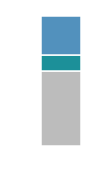

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(.8,2.5))
bottom = 0
for ml,c in zip(mirls,colors)[::-1]:
    ax.bar([0],[len(ml)],bottom=bottom,color=c,edgecolor='w',lw=1.5)
    bottom+=len(ml)
ax.axis('off')
fig.savefig(resultpath + '201125_f7b__fraction.pdf')

In [48]:
majorcsmp = defaultdict(list)
for mir in dcsmirsmp:
    c5, c3 = s3.loc[mir,["5' cleavage site","3' cleavage site"]]
    majorcsmp[mir].append(int(c5))
    if s3.loc[mir,'Cleavage ratio of alternative site']>=HOMCUT:
        majorcsmp[mir].append(int(s3.loc[mir,"5' alternative site"]))
print len(majorcsmp), majorcsmp['hsa-let-7d']

534 [23, 22]


In [98]:
majorcs = defaultdict(list)
for mir in dcsmirs:
    c5, c3 = s7.loc[mir,["5' cleavage site","3' cleavage site"]]
    majorcs[mir].append(int(c5))
    if s7.loc[mir,'Cleavage ratio of alternative site']>=HOMCUT:
        majorcs[mir].append(int(s7.loc[mir,"5' alternative site"]))
print len(majorcs), majorcs['hsa-let-7d']

749 [23]


In [100]:
mirs = [ m for m in dcsmirs if m in dcsmirsmp ]
print len(mirs)

shifted = {}
for m in mirs:
    csmp = majorcsmp[m]
    cs = majorcs[m]
    if set(csmp)!=set(cs):
        shifted[m] = (csmp, cs)
print len(shifted)

519
91


In [105]:
91/532

0.17105263157894737

(-0.44000000000000006, 0.44000000000000006, 0.0, 558.6)

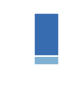

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(.5,1))
ax.bar([0],[91],bottom=0,color='#80b1d3',edgecolor='w',lw=1.5)
ax.bar([0],[441],bottom=91,color='#386cb0',edgecolor='w',lw=1.5)

ax.axis('off')
#fig.savefig(resultpath + '201125_f7b__fraction_v2.pdf')

In [69]:
dbov = [m for m in overlap if m in dbmirs]
mirls = [ [m for m in overlap if m in dcsmirsmp and m in dbov],
          [m for m in overlap if m not in dcsmirsmp and m in dcsmirs and m in dbov],
          [m for m in overlap if m in nodcs and m in nodcsmp and m in dbov] ]
data = map(len,mirls)
print data, np.array(data)/sum(data), sum(data)
colors = '#5291bd #1c9099 #bcbcbc'.split()

[344, 92, 62] [0.69076305 0.18473896 0.12449799] 498


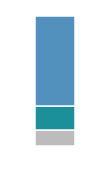

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(.8,2.5))
bottom = 0
for ml,c in zip(mirls,colors)[::-1]:
    ax.bar([0],[len(ml)],bottom=bottom,color=c,edgecolor='w',lw=1.5)
    bottom+=len(ml)
ax.axis('off')
fig.savefig(resultpath + '201125_f7b__fraction_mirgenedb.pdf')

In [70]:
depov = [m for m in overlap if m in drodep]
mirls = [ [m for m in overlap if m in dcsmirsmp and m in depov],
          [m for m in overlap if m not in dcsmirsmp and m in dcsmirs and m in depov],
          [m for m in overlap if m in nodcs and m in nodcsmp and m in depov] ]
data = map(len,mirls)
print data, np.array(data)/sum(data), sum(data)
colors = '#5291bd #1c9099 #bcbcbc'.split()

[205, 55, 35] [0.69491525 0.18644068 0.11864407] 295


(-0.44000000000000006, 0.44000000000000006, 0.0, 309.75)

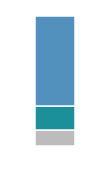

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(.8,2.5))
bottom = 0
for ml,c in zip(mirls,colors)[::-1]:
    ax.bar([0],[len(ml)],bottom=bottom,color=c,edgecolor='w',lw=1.5)
    bottom+=len(ml)
ax.axis('off')
#fig.savefig(resultpath + '201125_f7b__fraction_cano.pdf')

In [176]:
indov = [m for m in overlap if m in droind]
mirls = [ [m for m in overlap if m in dcsmirsmp and m in indov],
          [m for m in overlap if m not in dcsmirsmp and m in dcsmirs and m in indov],
          [m for m in overlap if m in nodcs and m in nodcsmp and m in indov] ]
data = map(len,mirls)
print data, np.array(data)/sum(data), sum(data)
colors = '#5291bd #1c9099 #bcbcbc'.split()

[3, 3, 248] [0.01181102 0.01181102 0.97637795] 254


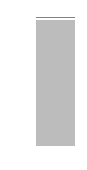

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(.8,2.5))
bottom = 0
for ml,c in zip(mirls,colors)[::-1]:
    ax.bar([0],[len(ml)],bottom=bottom,color=c,edgecolor='w',lw=1)
    bottom+=len(ml)
ax.axis('off')
fig.savefig(resultpath + '201125_f7b__fraction_noncano.pdf')

## S2B. Dropped miRNAs

In [180]:
depov = [m for m in overlap if m in drodep]
dbov = [m for m in overlap if m in dbmirs]
dropped = [m for m in depov if m in nodcs and m in nodcsmp]
print len(dbov), len(depov), len(dropped)

498 295 35


In [185]:
erh = pd.ExcelFile('supplementary/Kwon_2020_s1.xlsx')
erhtbl = erh.parse('Merged',index_col=0,header=6)
erhtbl.iloc[:1,:6]

,Nearest neighbor,Distance (nt),baseMean_siERH,log2FC_siERH,baseMean_DGCR8_dex2,log2FC_DGCR8_dex2
hsa-let-7a-1,hsa-let-7f-1,311,8683.520704,0.21942,96660.145445,0.294661


In [182]:
def is_dependent(mir, s, rcut, fcut):
    return (mir in erhtbl[(erhtbl['baseMean_%s'%s]>=rcut)&(erhtbl['log2FC_%s'%s]<=fcut)].index)

In [183]:
def is_sufficient(mir, s, rcut, fcut):
    return (mir in erhtbl[(erhtbl['baseMean_%s'%s]>=rcut)].index)

In [186]:
ERHCUT, SAFBCUT = 800, 50
FCCUT = -.5
suff = [ m for m in dropped if is_sufficient(m,'siERH',ERHCUT,FCCUT) or
                                  is_sufficient(m,'SAFB_DKO_293T',SAFBCUT,FCCUT) or 
                                  is_sufficient(m,'SAFB_DKO_Ramos',SAFBCUT,FCCUT) ]
erhsafb = [ m for m in dropped if is_dependent(m,'siERH',ERHCUT,FCCUT) or
                                  is_dependent(m,'SAFB_DKO_293T',SAFBCUT,FCCUT) or 
                                  is_dependent(m,'SAFB_DKO_Ramos',SAFBCUT,FCCUT) ]
print len(suff), len(erhsafb)

19 15


In [187]:
print '\n'.join(sorted([m for m in dropped if m not in suff])).replace('hsa-','')

mir-1343
mir-1908
mir-1914
mir-3619
mir-3911
mir-3917
mir-4326
mir-4421
mir-4473
mir-4664
mir-4783
mir-5008
mir-548o
mir-592
mir-6720
mir-6723


## C-E. Comparison with fCLIP

In [76]:
fclipexcel = pd.ExcelFile('supplementary/Kim_2017_s2.xlsx')
fclip293t = fclipexcel.parse('HEK293T_miRBase', index_col=0)
fcliphela = fclipexcel.parse('HeLa_miRBase', index_col=0)
both293t = fclip293t[(fclip293t['Group5p']!='Unidentified')
                     &(fclip293t['Group3p']!='Unidentified')]
bothhela = fcliphela[(fcliphela['Group5p']!='Unidentified')
                     &(fcliphela['Group3p']!='Unidentified')]

In [626]:
newly = [m for m in overlap if m not in dcsmirsmp and m in dcsmirs]
print len(newly)

227


In [643]:
fclcomp = {}
for mir in dcsmirs:
    c5, c3 = s7.loc[mir,["5' cleavage site","3' cleavage site"]]
    srsf3cs = [c5]
    if s7.loc[mir,'Cleavage ratio of alternative site']>=HOMCUT:
        srsf3cs.append(int(s7.loc[mir,"5' alternative site"]))
    
    cs, ce, strand = s2.loc[mir,['Start','End','Strand']]
    if strand=='+':
        srsf3cs = [ int(cs+c-1) for c in srsf3cs ]
    else:
        srsf3cs = [ int(ce-c+1) for c in srsf3cs ]

    if mir in both293t.index:
        fcl5cs = map(int, str(both293t.loc[mir, 'fCLIPPosition5p']).split(';'))
        fcl3cs = map(int, str(both293t.loc[mir, 'fCLIPPosition3p']).split(';'))
    elif mir in bothhela.index:
        fcl5cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition5p']).split(';'))
        fcl3cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition3p']).split(';'))
    else:
        continue
    fclcomp[mir] = (set(srsf3cs),set(fcl5cs))
print len(fclcomp)

239


In [644]:
print len(fclcomp), len([mir for mir,(s,f) in fclcomp.items() if s<=f])

239 220


In [645]:
220/239

0.9205020920502092

In [136]:
fclcomp = {}

for mir in newly:
    cs, ce, strand = s2.loc[mir,['Start','End','Strand']]
    srsf3cs = majorcs[mir]
    if strand=='+':
        srsf3cs = [ int(cs+c-1) for c in srsf3cs ]
    else:
        srsf3cs = [ int(ce-c+1) for c in srsf3cs ]

    if mir in both293t.index:
        fcl5cs = map(int, str(both293t.loc[mir, 'fCLIPPosition5p']).split(';'))
        fcl3cs = map(int, str(both293t.loc[mir, 'fCLIPPosition3p']).split(';'))
    elif mir in bothhela.index:
        fcl5cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition5p']).split(';'))
        fcl3cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition3p']).split(';'))
    else:
        continue
    
    fclcomp[mir] = (set(srsf3cs),set(fcl5cs))

In [139]:
print len(fclcomp), len([mir for mir,(s,f) in fclcomp.items() if s<=f])

52 43


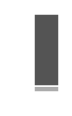

In [646]:
fig, ax = plt.subplots(1, 1, figsize=(.5,1.5))
ax.bar([0],[19],bottom=0,color='#ababab',edgecolor='w',lw=1.5)
ax.bar([0],[220],bottom=19,color='#545454',edgecolor='w',lw=1.5)

ax.axis('off')
fig.savefig(resultpath + '201125_f7e__fclip_site_comp.pdf')

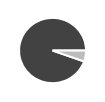

In [635]:
data = [226,13]
colors = '#424242 #bcbcbc'.split()
fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5))
ps,ts = ax.pie(data, colors=colors, wedgeprops={'linewidth':2,'edgecolor':'w'},
               startangle=0)
#fig.savefig(resultpath + '201123_f7e__fclip_site_comp_v2.pdf')

In [175]:
len([m for m in overlap if m in droind and m in dcsmirs])

5

## E. 5p nick processing

In [14]:
ps = 0.0002

In [648]:
mirs = s7['5p nick processing'].dropna().index
mirs = [m for m in mirs if m in s5['5p nick processing'].dropna().index ]
        #and s5.loc[m,'Set']=='set1']
print len(mirs)

955


In [653]:
tmp = ['hsa-mir-17','hsa-mir-10b','hsa-mir-20a']
xs = np.log2((s7.reindex(mirs)['5p nick processing']+s5.reindex(mirs)['5p nick processing'])/2)
ys = np.log2((s7.reindex(mirs)['5p nick processing']+ps)/\
             (s5.reindex(mirs)['5p nick processing']+ps))
xs2 = np.log2((s7.reindex(tmp)['5p nick processing']+s5.reindex(tmp)['5p nick processing'])/2)
ys2 = np.log2((s7.reindex(tmp)['5p nick processing']+ps)/\
             (s5.reindex(tmp)['5p nick processing']+ps))
data = zip(xs,ys)
xmin, xmax = -12, 5
ymin, ymax = -8, 5
xsc,ysc,fc = get_2d_density(data, xmin, xmax, ymin, ymax)
cmap = custom_cmap(['white','black'])
print len([x for x in xs if x>0])

105


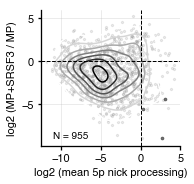

In [655]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs,ys,s=5,alpha=.2,color='#969696',zorder=2,rasterized=True)
ax.scatter(xs2,ys2,s=7,alpha=.7,color='#424242',zorder=3,rasterized=True)
ax.contour(xsc,ysc,fc,cmap=cmap,zorder=2)
ax.axhline(0,color='k',ls='--',lw=1)
ax.axvline(0,color='k',ls='--',lw=1)
ax.set_xlim(-12.5,5)
ax.set_xlabel('log2 (mean 5p nick processing)')
ax.set_ylabel('log2 (MP+SRSF3 / MP)')
ax.grid(ls='-',lw=.5)
ax.text(-11,-9,'N = %s'%len(xs))
fig.savefig(resultpath + '201128_f7e__nick_v2.pdf',dpi=300)

In [315]:
[(m,x,y) for m,x,y in zip(mirs,xs,ys) if y<-4 and x>0]

[('hsa-mir-10a', 0.7532036365690953, -5.48416014111619),
 ('hsa-mir-10b', 3.0631286430098053, -4.482263317932566),
 ('hsa-mir-1197', 1.8324882052104972, -4.294355808302247),
 ('hsa-mir-128-1', 0.7684696282538835, -4.489501825548224),
 ('hsa-mir-17', 2.713676441962103, -8.993868496509595),
 ('hsa-mir-199a-2', 1.3810282113907608, -4.017153600324488),
 ('hsa-mir-20a', 0.29465881052648124, -5.590629417281033),
 ('hsa-mir-215', 0.8678011532962171, -5.700293048319834),
 ('hsa-mir-224', 0.20085814138450073, -4.927314135701518),
 ('hsa-mir-23b', 1.8692290629461117, -4.63904835494512),
 ('hsa-mir-29a', 3.4025637540223683, -5.459821889334257),
 ('hsa-mir-30b', 2.0116300896026753, -4.115358609364048),
 ('hsa-mir-3125', 0.4624770712962665, -4.512051118956914),
 ('hsa-mir-3936', 2.1024892581772487, -4.653132068386971),
 ('hsa-mir-433', 1.3065510172536017, -4.339290585535224),
 ('hsa-mir-517b', 0.23866330561633825, -8.973301258624135),
 ('hsa-mir-543', 1.0491311835909873, -4.44035535908542),
 ('hsa-

## F. 3p nick processing

In [12]:
mirs = s7['3p nick processing'].dropna().index
mirs = [m for m in mirs if m in s5['3p nick processing'].dropna().index] 
        #and s5.loc[m,'Set']=='set1']
print len(mirs)

955


In [17]:
tmp = ['hsa-mir-16-2','hsa-mir-128-1','hsa-mir-30c-2']
xs = np.log2((s7.reindex(mirs)['3p nick processing']+s5.reindex(mirs)['3p nick processing'])/2)
ys = np.log2((s7.reindex(mirs)['3p nick processing']+ps)/\
             (s5.reindex(mirs)['3p nick processing']+ps))
xs2 = np.log2((s7.reindex(tmp)['3p nick processing']+s5.reindex(tmp)['3p nick processing'])/2)
ys2 = np.log2((s7.reindex(tmp)['3p nick processing']+ps)/\
             (s5.reindex(tmp)['3p nick processing']+ps))
data = zip(xs,ys)
xmin, xmax = -12, 1
ymin, ymax = -5, 5
xsc,ysc,fc = get_2d_density(data, xmin, xmax, ymin, ymax)
cmap = custom_cmap(['white','black'])
print len([x for x in xs if x>0])

35


In [97]:
import seaborn as sns

In [173]:
ms = [ m for m in mirs if m in overlap ]
mssub = [ 'hsa-mir-142','hsa-let-7c','hsa-mir-147b' ]
#mssub = [ 'hsa-mir-17','hsa-mir-10b','hsa-mir-20a' ]
#mssub =  ['hsa-mir-16-2','hsa-mir-128-1','hsa-mir-30c-2']
xs = np.log2((s7.reindex(mstmp)['Inverted processing']+ps)/\
             (s6.reindex(mstmp)['Inverted processing']+ps))
#xs = np.log2((s7.reindex(mstmp)['5p nick processing']+ps)/\
#             (s5.reindex(mstmp)['5p nick processing']+ps))
ys = [ effs[m]-effsmp[m] for m in mstmp ]
xssub = np.log2((s7.reindex(mssub)['Inverted processing']+ps)/\
                (s6.reindex(mssub)['Inverted processing']+ps))
#xssub = np.log2((s7.reindex(mssub)['5p nick processing']+ps)/\
#                (s5.reindex(mssub)['5p nick processing']+ps))
yssub = [ effs[m]-effsmp[m] for m in mssub ]
data = zip(xs,ys)
xmin, xmax = -5, 5
ymin, ymax = -1, 10
xsc,ysc,fc = get_2d_density(data, xmin, xmax, ymin, ymax)
r, p = spearmanr(xs,ys)
print r, p
print zip(mssub,xssub,yssub)

-0.5104123386784023 3.759506481805879e-64
[('hsa-mir-142', -3.9625412567873095, 7.263280255613465), ('hsa-let-7c', -6.137476163859865, 9.337610473052235), ('hsa-mir-147b', -9.477369426847744, 9.598064502167977)]


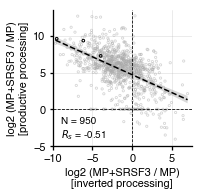

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
sns.regplot(x=xs, y=ys, color='#ababab',                            
        scatter_kws={'s':5,'alpha':.5,'zorder':2,'rasterized':True,'facecolor':'None','lw':.8},
        line_kws={'ls':'--','lw':1.5,'color':'k'}, ci=95)
ax.scatter(xssub,yssub,s=7,color='k',zorder=3,rasterized=True, facecolor='None',lw=1)
#ax.contour(xsc,ysc,fc,cmap=cmap,zorder=2)
ax.axhline(0,color='k',ls='--',lw=.8)
ax.axvline(0,color='k',ls='--',lw=.8)
#ax.set_xlim(-7,7)
#ax.set_xlim(-9.5,5)
ax.set_xlim(-10,7.5)
ax.set_ylim(-5,13.5)
ax.set_xlabel('log2 (MP+SRSF3 / MP)\n[inverted processing]')
ax.set_ylabel('log2 (MP+SRSF3 / MP)\n[productive processing]')
ax.grid(ls='-',lw=.5)
ax.text(-9,-4,'N = %s\n$R_s$ = %.2f'%(len(xs),r))
fig.savefig(resultpath + '201130_s7__productive_change_inverted_v2.pdf',dpi=300)

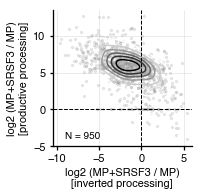

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xstmp,ystmp,s=5,alpha=.2,color='#969696',zorder=2,rasterized=True)
ax.contour(xsc,ysc,fc,cmap=cmap,zorder=2)
ax.axhline(0,color='k',ls='--',lw=1)
ax.axvline(0,color='k',ls='--',lw=1)
ax.set_xlim(-10.5,6)
ax.set_ylim(-5,13.5)
ax.set_xlabel('log2 (MP+SRSF3 / MP)\n[inverted processing]')
ax.set_ylabel('log2 (MP+SRSF3 / MP)\n[productive processing]')
ax.grid(ls='-',lw=.5)
ax.text(-9,-4,'N = %s'%len(xstmp))
fig.savefig(resultpath + '201130_s7__productive_change_inverted.pdf',dpi=300)

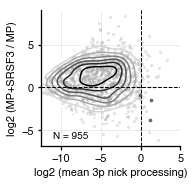

In [664]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs,ys,s=5,alpha=.2,color='#969696',zorder=2,rasterized=True)
ax.scatter(xs2,ys2,s=7,alpha=.7,color='#424242',zorder=3,rasterized=True)
ax.contour(xsc,ysc,fc,cmap=cmap,zorder=2)
ax.axhline(0,color='k',ls='--',lw=1)
ax.axvline(0,color='k',ls='--',lw=1)
ax.set_xlim(-12.5,5)
ax.set_xlabel('log2 (mean 3p nick processing)')
ax.set_ylabel('log2 (MP+SRSF3 / MP)')
ax.grid(ls='-',lw=.5)
ax.text(-11,-6,'N = %s'%len(xs))
fig.savefig(resultpath + '201128_f7e__nick3_v2.pdf',dpi=300)

In [502]:
zip(tmp, xs2, ys2)

[('hsa-mir-16-2', 1.219089103309968, -3.82856526884623),
 ('hsa-mir-92a-2', 0.9771565516456963, 0.5866235908158068),
 ('hsa-mir-128-1', 1.2987417764011029, -1.5116823640515122),
 ('hsa-mir-4268', 0.6768403086258605, -2.7805160346665976)]

## H. Inverted processing

In [656]:
mirs = s7['Inverted processing'].dropna().index
mirs = [m for m in mirs if m in s6['Inverted processing'].dropna().index]
print len(mirs)

955


In [658]:
tmp = ['hsa-mir-142','hsa-let-7c','hsa-mir-147b','hsa-mir-146a']
xs = np.log2((s7.reindex(mirs)['Inverted processing']+s6.reindex(mirs)['Inverted processing'])/2)
ys = np.log2((s7.reindex(mirs)['Inverted processing']+ps)/\
             (s6.reindex(mirs)['Inverted processing']+ps))
xs2 = np.log2((s7.reindex(tmp)['Inverted processing']+s6.reindex(tmp)['Inverted processing'])/2)
ys2 = np.log2((s7.reindex(tmp)['Inverted processing']+ps)/\
             (s6.reindex(tmp)['Inverted processing']+ps))
data = zip(xs,ys)
xmin, xmax = -12, 5
ymin, ymax = -8, 5
xsc,ysc,fc = get_2d_density(data, xmin, xmax, ymin, ymax)
print len([x for x in xs if x>0])

283


In [659]:
zip(tmp, xs2, ys2)

[('hsa-mir-142', 2.1814170485820945, -3.9625412567873095),
 ('hsa-let-7c', 5.351965064213164, -6.137476163859865),
 ('hsa-mir-147b', 5.644199490023744, -9.477369426847744),
 ('hsa-mir-146a', 6.367656065333252, -3.611344876140645)]

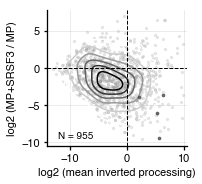

In [661]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs,ys,s=5,alpha=.2,color='#969696',zorder=2,rasterized=True)
ax.scatter(xs2,ys2,s=7,alpha=.7,color='#424242',zorder=3,rasterized=True)
ax.contour(xsc,ysc,fc,cmap=cmap,zorder=2)
ax.axhline(0,color='k',ls='--',lw=1)
ax.axvline(0,color='k',ls='--',lw=1)
ax.set_xlim(-14,10.5)
ax.set_xlabel('log2 (mean inverted processing)')
ax.set_ylabel('log2 (MP+SRSF3 / MP)')
ax.grid(ls='-',lw=.5)
ax.text(-12,-9.5,'N = %s'%len(xs))
fig.savefig(resultpath + '201128_f7g__inverted_v2.pdf',dpi=300)

In [337]:
[(m,x,y) for m,x,y in zip(mirs,xs,ys) if (x>9 and y<0)]

[('hsa-mir-3619', 9.478597856588864, -2.542955496335204),
 ('hsa-mir-4473', 9.730050844638093, -0.6194563339706785),
 ('hsa-mir-451b', 9.538716121119409, -4.546494242833875),
 ('hsa-mir-5682', 9.623099611787419, -6.806133747499408),
 ('hsa-mir-939', 9.798854758178893, -3.622717415223808)]

# C. change by CNNC

In [192]:
def find_cnnc(mir, cnnc):
    if mir in dcsmirs:
        pe = majorcs[mir][1]
    else:
        pe = preposition[mir][1]
    cnncseq = constseqs[mir][pe+14:pe+22]
    return bool(re.search(cnnc, cnncseq))

In [193]:
majorcs = {}
for mir in dcsmirs:
    c5, c3 = s7.loc[[mir],["5' cleavage site","3' cleavage site"]].iloc[0]
    majorcs[mir] = (int(c5),int(c3))
print len(majorcs), majorcs['hsa-let-7a-1']

749 (25, 96)


In [194]:
rescue = [m for m in overlap if m in dcsmirs and m in nodcsmp]
print len(rescue)

227


In [195]:
nc = [ m for m in overlap if m in droind ]
rescnnc = [ m for m in rescue if find_cnnc(m,'C[A-Z][A-Z]C') ]
rescnnd = [ m for m in rescue if (find_cnnc(m,'C[A-Z][A-Z][^C]') 
            or find_cnnc(m,'[^C][A-Z][A-Z]C')) and m not in rescnnc ]
rest = [ m for m in rescue if m not in rescnnc+rescnnd ]
print len(nc), len(rescnnc), len(rescnnd), len(rest)

254 157 63 7


In [201]:
mirls = [ nc, rescnnc, rescnnd, rest ]
ysl = [[ effs[m]-effsmp[m] for m in ml ] for ml in mirls]
cs = [ '#ababab','#6baed6','#9e9ac8','#fd8d3c' ]
labels = [ 'DRO-\nindep.','CNNC\n(%s)'%len(mirls[1]),
           'CNND\n or DNNC\n(%s)'%len(mirls[2]), 'Rest\n(%s)'%len(mirls[3])]
print ttest_ind(ysl[1],ysl[2],equal_var=False), ttest_ind(ysl[1],ysl[3],equal_var=False)
print ttest_ind(ysl[0],ysl[1]), ttest_ind(ysl[0],ysl[2]), ttest_ind(ysl[0],ysl[3])

Ttest_indResult(statistic=2.5100756342542976, pvalue=0.013559537689817982) Ttest_indResult(statistic=0.5913620580561435, pvalue=0.5715681549982985)
Ttest_indResult(statistic=-34.10886069966728, pvalue=1.149005824343114e-121) Ttest_indResult(statistic=-22.52541399816493, pvalue=1.3039494052899211e-67) Ttest_indResult(statistic=-10.643369321763485, pvalue=3.4994271195548443e-22)


In [202]:
print mannwhitneyu(ysl[1],ysl[2],alternative='two-sided')
print mannwhitneyu(ysl[2],ysl[3],alternative='two-sided')
print mannwhitneyu(ysl[0],ysl[1],alternative='two-sided')
print mannwhitneyu(ysl[0],ysl[2],alternative='two-sided')
print mannwhitneyu(ysl[0],ysl[3],alternative='two-sided')

MannwhitneyuResult(statistic=6136.0, pvalue=0.005300438920961186)
MannwhitneyuResult(statistic=189.0, pvalue=0.5439296035946066)
MannwhitneyuResult(statistic=586.0, pvalue=7.186700700377443e-62)
MannwhitneyuResult(statistic=388.5, pvalue=4.901327243849988e-32)
MannwhitneyuResult(statistic=3.0, pvalue=5.1657962606964256e-06)


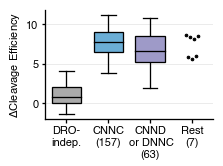

In [483]:
fig, ax = plt.subplots(1, 1, figsize=(3,2))
bp = ax.boxplot(ysl[:3], widths=.7, sym='',boxprops={'linewidth':1.3},capprops={'linewidth':1.3},
               medianprops={'linewidth':1.3,'color':'k'},whiskerprops={'linewidth':1.3},
               patch_artist=True,whis=1)
ax.set_ylabel('$\Delta$Cleavage Efficiency')
for box,c in zip(bp['boxes'],cs):
    box.set_facecolor(c)
xs = [4,3.9,4.1,4.05,3.95,4.15,3.85]
ax.scatter(xs, sorted(ysl[3]),s=7,color='k')
    
ax.set_xticks(range(1,1+len(mirls)))
ax.set_xticklabels(labels)
ax.yaxis.grid(ls='-',lw=.5)
ax.set_xlim(.5,4.5)
fig.savefig(resultpath + '201123_s7c__cnnc.pdf')

In [496]:
mirls = [ nc, rescnnc, rescnnd, rest ]
ysl = [[ homs[m]-homsmp[m] for m in ml ] for ml in mirls]
cs = [ '#ababab','#6baed6','#9e9ac8','#fd8d3c' ]
labels = [ 'DRO-\nindep.','CNNC\n(%s)'%len(mirls[1]),
           'CNND\n or DNNC\n(%s)'%len(mirls[2]), 'Rest\n(%s)'%len(mirls[3])]
print ttest_ind(ysl[1],ysl[2],equal_var=False), ttest_ind(ysl[2],ysl[3],equal_var=False)
print ttest_ind(ysl[0],ysl[1]), ttest_ind(ysl[0],ysl[2]), ttest_ind(ysl[0],ysl[3])

Ttest_indResult(statistic=4.403826612609833, pvalue=2.0936018795007208e-05) Ttest_indResult(statistic=1.441659316774231, pvalue=0.18654069988557587)
Ttest_indResult(statistic=-26.58771229582808, pvalue=3.563451785476006e-91) Ttest_indResult(statistic=-19.547266737345016, pvalue=2.800546692749563e-56) Ttest_indResult(statistic=-7.3416428465070815, pvalue=2.7319308770655126e-12)


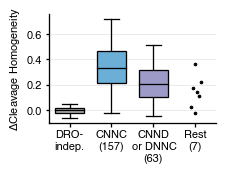

In [489]:
fig, ax = plt.subplots(1, 1, figsize=(3,2))
bp = ax.boxplot(ysl[:3], widths=.7, sym='',boxprops={'linewidth':1.3},capprops={'linewidth':1.3},
               medianprops={'linewidth':1.3,'color':'k'},whiskerprops={'linewidth':1.3},
               patch_artist=True,whis=1)
ax.set_ylabel('$\Delta$Cleavage Homogeneity')
for box,c in zip(bp['boxes'],cs):
    box.set_facecolor(c)
xs = [4,3.9,4.1,4.05,3.95,4.15,4]
ax.scatter(xs, sorted(ysl[3]),s=7,color='k')
    
ax.set_xticks(range(1,1+len(mirls)))
ax.set_xticklabels(labels)
ax.set_yticks([0,.2,.4,.6])
ax.yaxis.grid(ls='-',lw=.5)
ax.set_xlim(.5,4.5)
fig.savefig(resultpath + '201123_s7c__cnnc_hom.pdf')

In [497]:
mirls[3]

['hsa-mir-3163',
 'hsa-mir-3688-2',
 'hsa-mir-450b',
 'hsa-mir-617',
 'hsa-mir-548d-2',
 'hsa-mir-548f-2',
 'hsa-mir-1302-6']

In [611]:
len([m for m in dbov if m not in dcsmirs+dcsmirsmp])

62

In [619]:
tmp = [m for m in dbov if m not in dcsmirs+dcsmirsmp and find_cnnc(m,'C[A-Z][A-Z]C')]
sts = []
for mir in tmp:
    if mir in dcsmirs:
        pe = majorcs[mir][1]
    else:
        pe = preposition[mir][1]
    cnncseq = constseqs[mir][pe+14:pe+22]
    cnncstr = s4.loc[mir,'Secondary structure'][pe+14:pe+22]
    cnncstr = [1 if s=='M' else 0 for s in cnncstr]
    sts.append(cnncstr)

In [621]:
tmp = [m for m in dbov if m in dcsmirs+dcsmirsmp and find_cnnc(m,'C[A-Z][A-Z]C')]
sts2 = []
for mir in tmp:
    if mir in dcsmirs:
        pe = majorcs[mir][1]
    else:
        pe = preposition[mir][1]
    cnncseq = constseqs[mir][pe+14:pe+22]
    cnncstr = s4.loc[mir,'Secondary structure'][pe+14:pe+22]
    cnncstr = [1 if s=='M' else 0 for s in cnncstr]
    sts2.append(cnncstr)

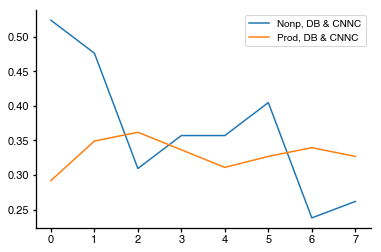

In [623]:
plt.plot(map(np.average,zip(*sts)),label='Nonp, DB & CNNC')
plt.plot(map(np.average,zip(*sts2)),label='Prod, DB & CNNC')
plt.legend()
plt.savefig(resultpath + 'tmp.pdf')

In [197]:
prod = [ m for m in overlap if m in dcsmirsmp ]
nonp = [ m for m in overlap if m in nodcsmp ]
nonpnc = [ m for m in nonp if m ]

noncnnc = [ m for m in nonp if find_cnnc(m,'C[A-Z][A-Z]C') ]
nonnocn = [ m for m in nonp if m not in noncnnc]
procnnc = [ m for m in prod if find_cnnc(m,'C[A-Z][A-Z]C') ]
pronocn = [ m for m in prod if m not in procnnc ]

print len(prod), len(nonp), len(procnnc), len(pronocn), len(noncnnc), len(nonnocn)

 532 1268 304 228 485 783


In [204]:
mirls = [ nonnocn, noncnnc, pronocn, procnnc ]
ysl = [[ effs[m]-effsmp[m] for m in ml ] for ml in mirls]
#ysl = [[homs[m]-homsmp[m] for m in ml ] for ml in mirls]
#cs = [ '#bababa','#f4a582','#bababa','#f4a582' ]
cs = [ '#bababa','#757575','#bababa','#757575' ]
labels = [ 'No\nCNNC','CNNC','No\nCNNC','CNNC' ]
print mannwhitneyu(ysl[0],ysl[1],alternative='two-sided')[1] 
print mannwhitneyu(ysl[2],ysl[3],alternative='two-sided')[1]
print mannwhitneyu(ysl[0]+ysl[1],ysl[2]+ysl[3],alternative='two-sided')[1]

#print ttest_ind(ysl[0],ysl[1],equal_var=False)[1] 
#print ttest_ind(ysl[2],ysl[3],equal_var=False)[1]
#print ttest_ind(ysl[0]+ysl[1],ysl[2]+ysl[3],equal_var=False)[1]

2.31912965573409e-17
0.0024544432961594817
1.6902984986869288e-91


In [189]:
ttest_ind?

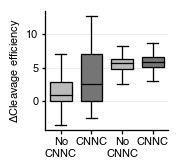

In [666]:
fig, ax = plt.subplots(1, 1, figsize=(2.2,2.2))
bp = ax.boxplot(ysl, widths=.7, sym='',boxprops={'linewidth':1.3},capprops={'linewidth':1.3},
               medianprops={'linewidth':1.3,'color':'k'},whiskerprops={'linewidth':1.3},
               patch_artist=True)
#ax.errorbar(range(1,5), map(np.average,ysl), yerr=map(sem,ysl))
ax.set_ylabel('$\Delta$Cleavage efficiency')
for box,c in zip(bp['boxes'],cs):
    box.set_facecolor(c)
#xs = [4,3.9,4.1,4.05,3.95,4.15,3.85]
#ax.scatter(xs, sorted(ysl[3]),s=7,color='k')
    
ax.set_xticks(range(1,1+len(mirls)))
ax.set_xticklabels(labels)
ax.yaxis.grid(ls='-',lw=.5)
ax.set_xlim(.5,4.5)
fig.savefig(resultpath + '201128_s7a__cnnc_eff.pdf')

In [203]:
mirls = [ nonnocn, noncnnc, pronocn, procnnc ]
#ysl = [[ effs[m]-effsmp[m] for m in ml ] for ml in mirls]
#ysl = [[abs(homs[m]-homsmp[m]) for m in ml ] for ml in mirls]
ysl = [[homs[m]-homsmp[m] for m in ml ] for ml in mirls]
print mannwhitneyu(ysl[0],ysl[1],alternative='two-sided')[1] 
print mannwhitneyu(ysl[2],ysl[3],alternative='two-sided')[1]
print mannwhitneyu(ysl[0]+ysl[1],ysl[2]+ysl[3],alternative='two-sided')[1]

1.5301905552507557e-16
0.00014804851608187398
1.5354789846400088e-10


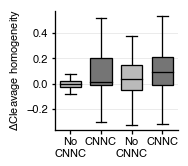

In [673]:
fig, ax = plt.subplots(1, 1, figsize=(2.2,2.2))
bp = ax.boxplot(ysl, widths=.7, sym='',boxprops={'linewidth':1.3},capprops={'linewidth':1.3},
               medianprops={'linewidth':1.3,'color':'k'},whiskerprops={'linewidth':1.3},
               patch_artist=True)
#ax.errorbar(range(1,5), map(np.average,ysl), yerr=map(sem,ysl))
ax.set_ylabel('$\Delta$Cleavage homogeneity')
for box,c in zip(bp['boxes'],cs):
    box.set_facecolor(c)
#xs = [4,3.9,4.1,4.05,3.95,4.15,3.85]
#ax.scatter(xs, sorted(ysl[3]),s=7,color='k')
    
ax.set_xticks(range(1,1+len(mirls)))
ax.set_xticklabels(labels)
ax.yaxis.grid(ls='-',lw=.5)
ax.set_xlim(.5,4.5)
fig.savefig(resultpath + '201128_s7c__cnnc_hom.pdf')

In [674]:
majorcs['hsa-mir-142']

(33, 89)

In [677]:
s3.loc['hsa-mir-17']

Cleavage Efficiency                    3.313092
Cleavage Homogeneity                   0.307937
5' miRBase site                       31.000000
3' miRBase site                       89.000000
5' cleavage site                      30.000000
3' cleavage site                      91.000000
5' alternative site                   28.000000
3' alternative site                   90.000000
Alternative Processing Ratio           0.056683
Cleavage ratio of alternative site     0.056683
Name: hsa-mir-17, dtype: float64

In [767]:
effdiff = {m:effs[m]-effsmp[m] for m in overlap }
dcsov = [ m for m in overlap if m in dcsmirs or m in dcsmirsmp ]
print len(dcsov)

756


In [1167]:
flank3 = {}
for mir in dcsov:
    if mir in dcsmirs:
        cs, ce = majorcs[mir]
    else:
        cs, ce = majorcsmp[mir]
    priseq = constseqs[mir]
    flank3[mir] = priseq[ce+14:min(125,ce+23)]

In [1168]:
ncut = 10
motifs = nmer(4)
mirls = { motif:[m for m in dcsov if motif in flank3[m]] for motif in motifs }
motifs = [motif for motif in motifs if len(mirls[motif])>=ncut]
ysl = [ [effdiff[m] for m in mirls[motif]] for motif in motifs ]
print map(len, ysl)

ms, ysl = zip(*sorted(zip(motifs,ysl), key=lambda x:np.average(x[1])))
ys = map(np.average, ysl)
es = map(sem, ysl)
xs = range(len(motifs))
print len(ms)
xssub = [ x for x,m in zip(xs,ms) if re.search('C[A-Z][A-Z]C',m)]
yssub = [ y for y,m in zip(ys,ms) if re.search('C[A-Z][A-Z]C',m)]
mssub = [ m for y,m in zip(ys,ms) if re.search('C[A-Z][A-Z]C',m)]

[12, 15, 12, 15, 17, 13, 16, 27, 26, 17, 25, 19, 14, 14, 10, 16, 11, 18, 32, 29, 16, 23, 10, 14, 13, 14, 16, 11, 68, 23, 20, 27, 30, 26, 32, 24, 13, 22, 25, 23, 25, 11, 35, 36, 12, 21, 10, 10, 10, 31, 26, 21, 10, 16, 13, 17, 13, 23, 10, 19, 47, 39, 16, 30, 11, 14, 17, 18, 13, 17, 18, 10, 34, 38, 10, 36, 29, 38, 28, 40, 20, 34, 50, 35, 17, 21, 14, 12, 23, 48, 30, 11, 11, 12, 13, 25, 14, 13, 13, 10, 12, 20, 25, 10, 11, 10, 15, 24, 39, 21, 49, 23, 15, 27, 34, 25, 10, 10, 11, 24, 24, 16, 22, 21, 18, 18, 51, 10, 19, 18, 52, 19, 11, 26, 71, 34, 29, 16, 50, 14, 12, 37, 17, 23, 61, 13, 28, 18, 63, 37, 41, 22, 46, 17, 16, 13, 18, 10, 13, 13, 12, 20, 15, 23, 32, 39, 15, 38, 26, 47, 12, 10, 14, 31, 28, 12, 24]
177


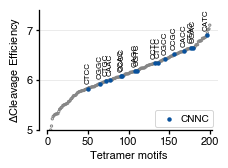

In [1150]:
fig, ax = plt.subplots(1, 1, figsize=(3.2,2.2))
#ax.errorbar(xs,ys,yerr=es)
ax.scatter(xs,ys,edgecolor='#858585',zorder=2,s=5,lw=1,facecolor='None')
ax.scatter(xssub,yssub,color='#08519c',lw=0,zorder=2,s=20,marker='o',label='CNNC')
for x,y,m in zip(xssub,yssub,mssub):
    ax.text(x,y+.1,m,rotation=90,ha='center',fontsize=8,va='bottom')
ax.set_xticks(range(0,len(ms),50))
ax.set_ylim(5,7.4)
ax.set_yticks(range(5,8))
ax.set_xlabel('Tetramer motifs')
ax.set_ylabel('$\Delta$Cleavage Efficiency')
ax.yaxis.grid(ls='-',lw=.5)
ax.legend(loc=(.65,.02),handletextpad=.1)
ax.spines['bottom'].set_bounds(0,len(ms)+2)
#fig.savefig(resultpath+ '201119_f6d__motif.pdf')

In [957]:
print ys[-58], ys[58]

6.421031898293488 5.8428662899542685


In [1169]:
tbl = pd.DataFrame(index=list('ATGC'),columns=range(4))
n = 50
sres = ms[-n:]
for i in range(4):
    for nuc in 'ATGC':
        tbl.loc[nuc,i] = len([sre for sre in sres if sre[i]==nuc])/n

In [1153]:
tbl

,0,1,2,3
A,0.24,0.28,0.28,0.36
T,0.34,0.24,0.26,0.24
G,0.08,0.1,0.16,0.12
C,0.34,0.38,0.3,0.28


(-0.5, 3.5, 0.0, 1.0)

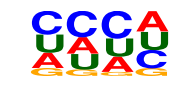

In [1170]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,1.2))
for i in range(4):
    freqd = tbl[i].to_dict()
    sortf = sorted(freqd.items(),key=lambda x:x[1])
    bottom = 0
    for nuc, f in sortf:
        letterAt(nuc.replace('T','U'),i,bottom,f,ax=ax)
        bottom+=f
        
ax.set_xlim(-.5,3.5)
ax.axis('off')
#fig.savefig(resultpath + '201119_f6e__meme.pdf')

In [1116]:
tbl = pd.DataFrame(index=list('ATGC'),columns=range(4))
n = 58
sres = ms[:n]
for i in range(4):
    for nuc in 'ATGC':
        tbl.loc[nuc,i] = len([sre for sre in sres if sre[i]==nuc])/n

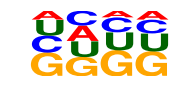

In [1118]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,1.2))
for i in range(4):
    freqd = tbl[i].to_dict()
    sortf = sorted(freqd.items(),key=lambda x:x[1])[::-1]
    bottom = 0
    for nuc, f in sortf:
        letterAt(nuc.replace('T','U'),i,bottom,f,ax=ax)
        bottom+=f
        
ax.set_xlim(-.5,3.5)
ax.axis('off')
fig.savefig(resultpath + '201119_f6e__meme2.pdf')

In [1114]:
n = 58
sres = ms[-n:]
dimers = defaultdict(int)
for sre in sres:
    for i in range(3):
        dimers[sre[i:i+2]]+=1

In [1054]:
fang = pd.ExcelFile('supplementary/Fang_2015_s3.xlsx')
organisms = fang.sheet_names

In [993]:
mottbl = pd.DataFrame(columns=range(30),index=organisms).fillna(0)
for org in organisms:
    tbl = fang.parse(org,header=2,index_col=0)
    for seq3 in tbl["3' flanking (5' to 3')"]:
        for i in range(30):
            if seq3[i]=='G':#[i:i+4].count('G')>=2:

                mottbl.loc[org,i]+=1
    mottbl.loc[org] = mottbl.loc[org]/len(tbl.index)*100

Text(0.945,0.5,u'miRNAs with G-rich motif (%)')

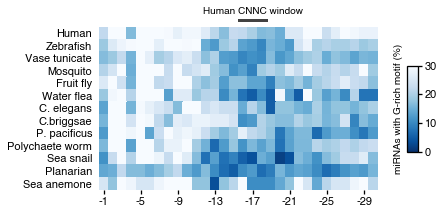

In [994]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
im = ax.pcolor(mottbl,vmin=0,vmax=30,cmap='Blues_r')
ax.invert_yaxis()
ax.set_yticks(np.arange(len(organisms))+.5)
ax.set_yticklabels(organisms)
ax.tick_params(left='off')
ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
ax.set_xticks(np.arange(0,30,4)+.5)
ax.set_xticklabels(range(-1,-30,-4))
l = lines.Line2D([15,18],[-.5,-.5],color='#424242',lw=3); ax.add_line(l); l.set_clip_on(False)
ax.text(16.5,-1,'Human CNNC window',ha='center')

axcb = fig.add_axes([.98,.3,.03,.4])
cb = plt.colorbar(im,cax=axcb)
cb.set_ticks(range(0,31,10))
fig.text(.945,.5,'miRNAs with G-rich motif (%)',va='center',rotation=90)
#fig.savefig(resultpath+'201016_grich.png',dpi=300)

In [1222]:
mottbl = pd.DataFrame(columns=range(30),index=organisms).fillna(0)
ns = {}
for org in organisms:
    tbl = fang.parse(org,header=2,index_col=0)
    ns[org] = len(tbl.index)
    for seq3 in tbl["3' flanking (5' to 3')"]:
        for i in range(30):
            if seq3[i:i+4].count('G')<=1 and seq3[i:i+4].count('C')>=1:
            #if re.search('C[C|G][C|G]C',seq3[i:i+4]):
                mottbl.loc[org,i]+=1
    mottbl.loc[org] = mottbl.loc[org]/len(tbl.index)*100

In [1223]:
labels = [ '%s (%s)'%(org,ns[org]) for org in organisms ]

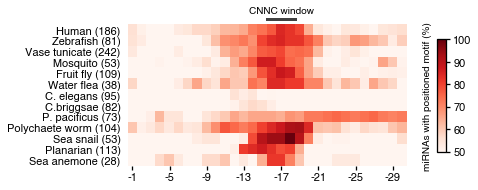

In [1228]:
fig, ax = plt.subplots(1,1,figsize=(5,2.6))
im = ax.pcolor(mottbl,cmap='Reds',vmin=50,vmax=100)
ax.invert_yaxis()
ax.set_yticks(np.arange(len(organisms))+.5)
ax.set_yticklabels(labels)
ax.tick_params(left='off')
ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
ax.set_xticks(np.arange(0,30,4)+.5)
ax.set_xticklabels(range(-1,-30,-4))
l = lines.Line2D([15,18],[-.5,-.5],color='#424242',lw=3); ax.add_line(l); l.set_clip_on(False)
ax.text(16.5,-1,'CNNC window',ha='center')
axcb = fig.add_axes([.985,.2,.025,.6])
cb = plt.colorbar(im,cax=axcb)
#cb.set_ticks(range(20,61,10))
cb.set_ticks(range(50,101,10))
cb.solids.set_rasterized(True)
fig.text(.945,.5,'miRNAs with positioned motif (%)',va='center',rotation=90)
fig.savefig(resultpath+'201119_f6f__c1g1.pdf',dpi=300)

In [1232]:
data = [ len([ m for m in rescue if any([find_cnnc(m,pos) for pos in [-16,-17,-18]])]),
         len([ m for m in rescue if any([find_chhh(m,pos) for pos in [-16,-17,-18]])]) ]
data = np.array(data)/len(rescue)*100

In [1244]:
data

array([55.35714286, 94.19642857])

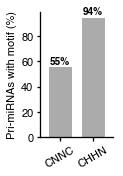

In [1251]:
fig, ax = plt.subplots(1, 1, figsize=(1.3,2.3))
#ax.bar([0,1],[100,100],width=.8,color='#bcbcbc',alpha=.2)
ax.bar([0,1],data,color='#ababab',width=.7)
ax.set_xlim(-.6,1.6)
ax.set_ylabel('Pri-miRNAs with motif (%)')
ax.set_xticks([0,1])
ax.set_xticklabels(['CNNC','CHHN'],rotation=30)
ax.text(0,58,'55%',ha='center',weight='bold')
ax.text(1,97,'94%',ha='center',weight='bold')
fig.savefig(resultpath + '201119_f6g__explained.pdf')

In [1252]:
len([m for m in cano if m in overlap])

294

In [1217]:
len([ m for m in rescue if any([find_cnnc(m,pos) for pos in [-16,-17,-18]])])

154

In [1221]:
len([ m for m in rescue if any([find_chhh(m,pos) for pos in [-16,-17,-18]])])

211

In [1216]:
def find_cnnc(mir, pos):
    seq = ''.join(seq3tbl.loc[mir,range(pos-3,pos+1)].fillna(''))
    return bool(re.search('C[A-Z][A-Z]C', seq))

In [1219]:
def find_chhh(mir, pos):
    seq = ''.join(seq3tbl.loc[mir,range(pos-3,pos+1)].fillna(''))
    return bool(seq.count('G')<=1 and seq.count('C')>=1)

In [1211]:
len([ m for m in rescue if ])

124

In [845]:
flank5 = {}
for mir in dcsov:
    if mir in dcsmirs:
        cs, ce = majorcs[mir]
    else:
        cs, ce = majorcsmp[mir]
    priseq = constseqs[mir]
    flank5[mir] = priseq[max(0,cs-26):cs-14]
print flank5['hsa-mir-16-1']

TATGATAGCAAT


In [790]:
ncut = 20
motifs = nmer(4)
mirls = { motif:[m for m in dcsov if motif in flank5[m]] for motif in motifs }
motifs = [motif for motif in motifs if len(mirls[motif])>=ncut]
ysl = [ [effdiff[m] for m in mirls[motif]] for motif in motifs ]
print map(len, ysl)

ms, ysl = zip(*sorted(zip(motifs,ysl), key=lambda x:np.average(x[1])))
ys = map(np.average, ysl)
es = map(sem, ysl)
xs = range(len(motifs))

xssub = [ x for x,m in zip(xs,ms) if re.search('C[A-Z][A-Z]C',m)]
yssub = [ y for y,m in zip(ys,ms) if re.search('C[A-Z][A-Z]C',m)]
mssub = [ m for y,m in zip(ys,ms) if re.search('C[A-Z][A-Z]C',m)]

[41, 49, 36, 24, 31, 42, 28, 27, 92, 34, 25, 29, 26, 29, 23, 29, 38, 28, 47, 35, 31, 34, 50, 22, 24, 31, 30, 89, 67, 51, 36, 35, 32, 25, 33, 30, 37, 72, 36, 44, 25, 28, 31, 26, 29, 36, 23, 44, 43, 29, 30, 21, 31, 22, 40, 23, 23, 24, 27, 33, 20, 32, 44, 39, 41, 32, 39, 29, 24, 54, 68, 30, 39, 41, 42, 31, 30, 47, 63, 36, 57, 33, 29, 22, 67, 32, 34, 38, 52, 29, 24, 49, 53, 38, 45, 51, 28, 48, 42, 71, 21, 27, 29, 45, 33, 47, 27, 45, 66, 27, 32, 39, 20, 21, 37, 22, 25, 41, 40, 23, 38, 34, 33, 37, 30, 72, 30, 21, 20, 36, 35, 39, 42, 31, 54, 26, 39, 33, 22, 36, 64, 33, 36, 41, 48, 28, 32, 71, 20, 21, 46, 31, 34, 59, 34, 33, 47, 36, 40, 44, 31, 20, 22, 44, 35, 50, 52, 70, 49, 45, 44, 32, 47, 22, 32, 47, 53, 37, 26, 47, 56, 39, 23, 22, 43, 50, 26, 34]


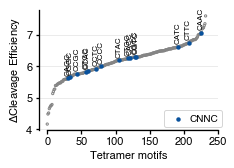

In [778]:
fig, ax = plt.subplots(1, 1, figsize=(3.2,2.2))
#ax.errorbar(xs,ys,yerr=es)
ax.scatter(xs,ys,edgecolor='#858585',zorder=2,s=5,lw=1,facecolor='None')
ax.scatter(xssub,yssub,color='#08519c',lw=0,zorder=2,s=20,marker='o',label='CNNC')
for x,y,m in zip(xssub,yssub,mssub):
    ax.text(x,y+.1,m,rotation=90,ha='center',fontsize=8,va='bottom')
ax.set_xticks(range(0,251,50))
ax.set_xlabel('Tetramer motifs')
ax.set_ylabel('$\Delta$Cleavage Efficiency')
ax.yaxis.grid(ls='-',lw=.5)
ax.legend(loc=(.7,.02),handletextpad=.1)
ax.spines['bottom'].set_bounds(0,250)
#fig.savefig(resultpath+ '201119_f6d__motif_tmp.pdf')

In [771]:
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
fp = FontProperties(family="Helvetica", weight="bold") 
globscale = 1.35
LETTERS = { "U" : TextPath((-0.305, 0), "U", size=1, prop=fp),
            "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
            "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
            "C" : TextPath((-0.366, 0), "C", size=1, prop=fp) }
COLOR_SCHEME = {'G': 'orange', 
                'A': 'red', 
                'C': 'blue', 
                'U': 'darkgreen'}
def letterAt(letter, x, y, yscale=1, ax=None):
    text = LETTERS[letter]
    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

NameError: name 'forlogo' is not defined

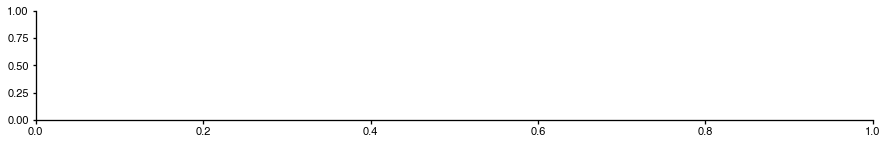

In [748]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,2))
all_scores = forlogo
x = 1
maxi = 0
for i in range(len(all_scores)):
    y = 0
    scores = all_scores.iloc[i,:].transpose().sort_values(ascending=False).to_dict()
    #print(scores.to_dict())
    #for j,base in enumerate(['A','C','G','T']):
    height = 6/(3**(sum([x!=0 for x in scores.values()])))
    for key in scores.keys():
        score = scores[key]
        #print(all_scores.index)
        base = key 
        if(score==1.5):
            letterAt(base, x,y, height, ax)
            y += height
    #for j,base in enumerate(['A','C','G','T']):
    for key in scores.keys():
        score = scores[key]
        #print(all_scores.index)
        base = key 
        if(score!=1.5 and score!=0):
            letterAt(base, x,y, height, ax)
            y += height
    x += 1
    maxi = max(maxi, y)
plt.xticks(range(1,x))
plt.xlim((0, x)) 
plt.ylim((0, maxi)) 
plt.tight_layout()


# C. Classification changes

In [148]:
single = set(s8[s8['Cleavage type']=='single'].index)
multi = set(s8[s8['Cleavage type']=='multiple'].index)
inverted = set(s8[s8['Cleavage type']=='inverted'].index)
nick5 = set(s8[s8['Cleavage type']=='nick5'].index)
nick3 = set(s8[s8['Cleavage type']=='nick3'].index)
nick = list(nick5) + list(nick3)
nonspec = set(s8[s8['Cleavage type']=='non-specific'].index)
dcsmirs = list(single) + list(multi)
nodcs = list(inverted) + list(nick) + list(nonspec)
print 'Productive: %s, Unproductive: %s' % (len(dcsmirs), len(nodcs))
print 'Single: %s, Multiple: %s, Inverted: %s, Nick: %s, Non-specific: %s'\
% (len(single), len(multi), len(inverted), len(nick), len(nonspec))
print "5' nick: %s, 3' nick: %s" % (len(nick5), len(nick3))

Productive: 694, Unproductive: 1106
Single: 597, Multiple: 97, Inverted: 105, Nick: 68, Non-specific: 933
5' nick: 39, 3' nick: 29


In [149]:
xs1 = map(lambda x: len([m for m in x if m in overlap]),
          [singlemp,multimp,nick5mp,nick3mp,invertedmp,nonspecmp])
xs2 = map(len, [single,multi,nick5,nick3,inverted,nonspec])
ys = np.arange(len(xs1))

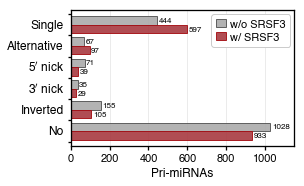

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(4,2.5))
ax.barh(ys-.2, xs1, height=.4, facecolor='#ababab', edgecolor='#545454',label='w/o SRSF3',
       zorder=2, alpha=.9)
ax.barh(ys+.2, xs2, height=.4, facecolor='#a83940', edgecolor='#a50f15',label='w/ SRSF3',
       zorder=2, alpha=.9)
for x1,x2,y in zip(xs1,xs2,ys):
    ax.text(x1+8,y-.2,x1,fontsize=8,va='center')
    ax.text(x2+8,y+.23,x2,fontsize=8,va='center')

ax.set_xlim(0,1150)
ax.spines['top'].set_visible(True); ax.spines['right'].set_visible(True); 
ax.legend(loc=(.63,.73), handlelength=.9,prop={'size':11},
          framealpha=1,handletextpad=.4,labelspacing=.3)
ax.invert_yaxis()
ax.xaxis.grid(ls='-',lw=.5)
ax.set_yticks(ys)
ax.set_yticks([-.5]+list(ys+.5),minor=True)
ax.set_yticklabels(['Single','Alternative','5$^\prime$ nick','3$^\prime$ nick','Inverted','No'],
                  fontsize=12,va='center')
ax.set_xlabel('Pri-miRNAs', fontsize=12)
ax.tick_params(left='off', which='major')
ax.tick_params(length=3,width=1.3, which='minor')
fig.savefig(resultpath + '201016_f5c__classification_change_hiseq.pdf')

# D. SRSF3-responsive element - tetramer motifs

In [166]:
effdiff = {m:effs[m]-effsmp[m] for m in overlap }
dboverlap = [m for m in dbmirs if m in overlap] 
print len(dboverlap)

513


In [164]:
cnst, cnen = 15, 19
f5seqs, f3seqs = {},{}
for mir in dboverlap:
    ps, pe = preposition[mir]
    f5seqs[mir] = constseqs[mir][max(0,ps-cnen-4):ps-cnst]
    f3seqs[mir] = constseqs[mir][pe+cnst-1:min(pe+cnen+3,125)]
print f5seqs['hsa-mir-16-1'], f3seqs['hsa-mir-16-1']
print len(f5seqs)

GATAGCAA TACTCTAC
513


In [195]:
n = 4
allmotifs = nmer(n)
motbl = pd.DataFrame(columns=['p_3f','fc_3f'])
for motif in allmotifs:
    for label,fseqs in zip(['5f','3f'],[f5seqs,f3seqs])[1:]:
        motvs = [ effdiff[m] for m in dboverlap if motif in fseqs[m] ]
        nomvs = [ effdiff[m] for m in dboverlap if motif not in fseqs[m] ]
        if len(motvs)>=5:
            pv = ttest_ind(motvs, nomvs, equal_var=False)[1]
            fc = np.average(motvs)-np.average(nomvs)
            motbl.loc[motif,'p_%s'%label] = pv
            motbl.loc[motif,'fc_%s'%label] = fc
print len(motbl)
motbl.head(3)

174


,p_3f,fc_3f
AAAA,0.651493,0.0867232
AAAC,0.170407,0.326009
AATG,0.153538,-1.63725


In [196]:
#motbl['padj_5f'] = sm.stats.multipletests(motbl['p_5f'],method='fdr_bh')[1]
motbl['padj_3f'] = sm.stats.multipletests(motbl['p_3f'],method='fdr_bh')[1]
motbl.head(3)

,p_3f,fc_3f,padj_3f
AAAA,0.651493,0.0867232,0.923282
AAAC,0.170407,0.326009,0.529478
AATG,0.153538,-1.63725,0.494735


In [197]:
fr = '3f'
pcut, fccut = .05, 0
xs = motbl[(motbl['padj_%s'%fr]>=pcut)|(abs(motbl['fc_%s'%fr])<=fccut)]['fc_%s'%fr]
ys = -np.log10(motbl[(motbl['padj_%s'%fr]>=pcut)|(abs(motbl['fc_%s'%fr])<=fccut)]\
['padj_%s'%fr].tolist())
xsig1 = motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]>fccut)]['fc_%s'%fr]
ysig1 = -np.log10(motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]>fccut)]\
['padj_%s'%fr].tolist())
xsig2 = motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]<-fccut)]['fc_%s'%fr]
ysig2 = -np.log10(motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]<-fccut)]\
['padj_%s'%fr].tolist())
print len(xs),len(ys),len(xsig1),len(ysig1),len(xsig2),len(ysig2)

ecns, fcns = '#252525', '#757575'
ecsig1, fcsig1 = '#a50f15', '#de2d26'
ecsig2, fcsig2 = '#08519c', '#3182bd'

170 170 4 4 0 0


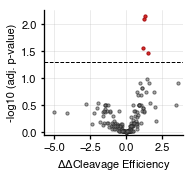

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.3))

ax.axhline(-np.log10(pcut), ls='--', color='k', lw=1, zorder=2)
ax.scatter(xs, ys, s=10, edgecolor=ecns, facecolor=fcns, lw=1, zorder=2, alpha=.6)
ax.scatter(xsig1, ysig1, s=10, edgecolor=ecsig1, facecolor=fcsig1, lw=1, zorder=3)
#ax.scatter(xsig2, ysig2, s=10, edgecolor=ecsig2, facecolor=fcsig2, lw=1, zorder=3)

ax.set_xlabel('$\Delta\Delta$Cleavage Efficiency')
ax.set_ylabel('-log10 (adj. p-value)')
ax.set_xlim(min(xs)*1.15,max(xs)*1.1)
ax.set_ylim(-max(ysig1)*.02, max(ysig1)*1.05)
#ax.set_yticks(range(0,11,2))
#ax.spines['left'].set_bounds(0,10)
ax.grid(ls='-',lw=.5)

# for motif in ['CAAC','CTAC','TACT']:
#     ax.text(motbl.loc[motif,'fc_%s'%fr],-np.log10(motbl.loc[motif,'padj_%s'%fr])+.35,
#             motif.replace('T','U'),fontsize=7,color=ecsig1,va='center')
    
# for motif in ['AGCA','GCAA','TTAC','CAGC']:
#     ax.text(motbl.loc[motif,'fc_%s'%fr]-.05,-np.log10(motbl.loc[motif,'padj_%s'%fr])+.1,
#             motif.replace('T','U'),fontsize=7,color=ecsig1,va='center',ha='right')
    
# ax.text(2.2,3.4,'UACA',fontsize=7,color=ecsig1)
# ax.text(2.25,2.1,'AUAC',fontsize=7,color=ecsig1)

# for motif in ['GAGG','GGCC','GGGA','GGAG','AGGT','AGAA']:
#     ax.text(motbl.loc[motif,'fc_%s'%fr]+.1,-np.log10(motbl.loc[motif,'padj_%s'%fr])+.1,
#             motif.replace('T','U'),fontsize=7,color=ecsig2,va='center')
    
# for motif in ['GGAA','CGTA','AGAG']:
#     ax.text(motbl.loc[motif,'fc_%s'%fr]-.1,-np.log10(motbl.loc[motif,'padj_%s'%fr])-.2,
#             motif.replace('T','U'),fontsize=7,color=ecsig2,va='top',ha='center')
# ax.text(-1.1,3.2,'UGGG,UGAG,CUGG',fontsize=7,color=ecsig2)
# ax.text(-1.1,2.65,'AAGG,GAGA,AUGA',fontsize=7,color=ecsig2)
# ax.text(-1.6,3.95,'GAUG,AGGA',fontsize=7,color=ecsig2)
# ax.text(-2.3,2.3,'GGGC\nGGUG\n AGGG',fontsize=7,color=ecsig2,linespacing=.9)
fig.savefig(resultpath + '201119_f6d__tetramer_3p.pdf')#,dpi=300)

In [379]:
motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]>fccut)].index

Index([u'ATAC', u'AGCA', u'TACA', u'TACT', u'TTAC', u'GCAA', u'CAAC', u'CAGC',
       u'CTAC'],
      dtype='object')

In [214]:
fr = '5f'
pcut, fccut = .01, .01
xs = motbl[(motbl['padj_%s'%fr]>=pcut)|(abs(motbl['fc_%s'%fr])<=fccut)]['fc_%s'%fr]
ys = -np.log10(motbl[(motbl['padj_%s'%fr]>=pcut)|(abs(motbl['fc_%s'%fr])<=fccut)]\
['padj_%s'%fr].tolist())
xsig1 = motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]>fccut)]['fc_%s'%fr]
ysig1 = -np.log10(motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]>fccut)]\
['padj_%s'%fr].tolist())
xsig2 = motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]<-fccut)]['fc_%s'%fr]
ysig2 = -np.log10(motbl[(motbl['padj_%s'%fr]<pcut)&(motbl['fc_%s'%fr]<-fccut)]\
['padj_%s'%fr].tolist())
print len(xs),len(ys),len(xsig1),len(ysig1),len(xsig2),len(ysig2)

ecns, fcns = '#252525', '#757575'
ecsig1, fcsig1 = '#a50f15', '#de2d26'
ecsig2, fcsig2 = '#08519c', '#3182bd'

237 237 1 1 18 18


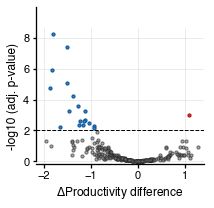

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(3,2.5))

ax.axhline(-np.log10(pcut), ls='--', color='k', lw=1, zorder=2)
ax.scatter(xs, ys, s=10, edgecolor=ecns, facecolor=fcns, lw=1, zorder=2, alpha=.6)
ax.scatter(xsig1, ysig1, s=10, edgecolor=ecsig1, facecolor=fcsig1, lw=1, zorder=3)
ax.scatter(xsig2, ysig2, s=10, edgecolor=ecsig2, facecolor=fcsig2, lw=1, zorder=3)

ax.set_xlabel('$\Delta$Productivity difference', fontsize=12)
ax.set_ylabel('-log10 (adj. p-value)', fontsize=12)
ax.set_xlim(min(min(xs),min(xsig2))*1.1,max(xs)*1.1)
ax.set_ylim(-max(ysig2)*.02, max(ysig2)*1.05)
ax.set_yticks(range(0,10,2))
ax.spines['left'].set_bounds(0,10)
ax.grid(ls='-',lw=.5)

# for motif in ['GGTG','AGGT','TGGG','GGGA']:
#     ax.text(motbl.loc[motif,'fc_%s'%fr]+.1,-np.log10(motbl.loc[motif,'padj_%s'%fr])+.15,
#             motif.replace('T','U'),fontsize=7,color=ecsig2,va='center')
# for motif in ['CGTA','TTAG','GGGT']:
#     ax.text(motbl.loc[motif,'fc_%s'%fr]+.15,-np.log10(motbl.loc[motif,'padj_%s'%fr])+.3,
#             motif.replace('T','U'),fontsize=7,color=ecsig2,ha='center')
# ax.text(-1.7,3.7,'GGGG\nTAGG    ',fontsize=7,color=ecsig2,ha='right',linespacing=.9)
# ax.text(-1,2.1,'AGGG GGCC CUCU\n CUGG CCUG',fontsize=7,color=ecsig2,linespacing=.95)
# ax.text(-1.3,3.8,'GUGG CAGG\n   GGAG',va='top',fontsize=7,color=ecsig2,linespacing=.9)
#fig.savefig(resultpath + '200924_f5d__tetramer_5p.pdf')#,dpi=300)

# E. SRSF3-responsive element - sequence content

In [218]:
ptop = set(dcsmirsmp)&set(dcsmirs)
nptop = set(nodcsmp)&set(dcsmirs)
nptonp = set(nodcsmp)&set(nodcs)
print len(ptop), len(nptop), len(nptonp)

476 218 1071


In [219]:
nfreq = {}
for mir in f3seqs:
    if len(f3seqs[mir])>=4:
        nfreq[mir] = [ f3seqs[mir].count(nuc)/len(f3seqs[mir]) for nuc in 'ACGT' ]

In [220]:
datanpnp = zip(*[nfreq[m] for m in nptonp if m in nfreq])
norm = np.array(map(np.average, datanpnp))

datapp = zip(*[nfreq[m] for m in ptop if m in nfreq])
ypp = np.array(map(np.average, datapp))/norm; epp = map(sem,datapp)

datanpp = zip(*[nfreq[m] for m in nptop if m in nfreq])
ynpp = np.array(map(np.average, datanpp))/norm; enpp = map(sem,datanpp)

ynpnp = np.array(map(np.average, datanpnp))/norm; enpnp = map(sem,datanpnp)

xnpnp = np.arange(4)-.26
xpp = np.arange(4)
xnpp = np.arange(4)+.26
width = .23

0.3031280768061941 0.1500340209294205
4.662830363218648e-06 1.214742033687698e-05
2.233876150693319e-11 1.1801166534146395e-06
0.5475802514863868 0.12149914942173624


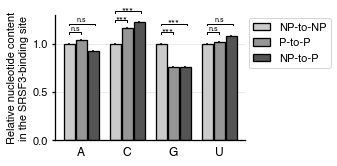

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(3.4,2.3))
ax.bar(xnpnp,ynpnp,yerr=enpnp,width=width,color='#cbcbcb',edgecolor='k',lw=1.3,zorder=2,
      label='NP-to-NP')
ax.bar(xpp,ypp,yerr=epp,width=width,color='#969696',edgecolor='k',lw=1.3,zorder=2,
      label='P-to-P')
ax.bar(xnpp,ynpp,yerr=enpp,width=width,color='#545454',edgecolor='k',lw=1.3,zorder=2,
      label='NP-to-P')
ax.set_xticks([])
ax.legend(handlelength=1.5, prop={'size':11}, loc=(1.02,.58))
for i,nuc in zip(range(4),list('ACGU')):
    ax.text(i,-.16,nuc,fontsize=12,ha='center')

for i,dy in zip(range(4),[.1,.23,.1,.1]):
    for dx in [0,.3]:
        l = lines.Line2D([i-.26,i-.26,i+dx,i+dx],
            [1+dy+dx*.3,1.02+dy+dx*.3,1.02+dy+dx*.3,1+dy+dx*.3],ls='-',lw=1,color='k')
        ax.add_line(l); l.set_clip_on(False)
        
for i,dy in zip(range(4),[.15,.28,.15,.15]):
    p1=ttest_ind(datanpnp[i],datapp[i])[1]
    p2=ttest_ind(datanpnp[i],datanpp[i])[1]
    print p1,p2
    if p1<.0005: ax.text(i-.13,1+dy-.06,'***',ha='center')
    else: ax.text(i-.13,1+dy-.01,'n.s',fontsize=7,ha='center')
    if p2<.0005: ax.text(i,1+dy+.03,'***',ha='center')
    else: ax.text(i,1+dy+.08,'n.s',fontsize=7,ha='center')
        
ax.set_ylabel('Relative nucleotide content\nin the SRSF3-binding site',fontsize=11)
ax.tick_params(bottom='off')
ax.yaxis.grid(ls='-',lw=.5)
fig.savefig(resultpath + '201016_f5e__nucleotide_content_hiseq.pdf')#,dpi=300)

# F. Secondary structure of SRSF3-responsive miRNAs

In [224]:
rescue = [ m for m in overlap if m not in dcsmirsmp and m in dcsmirs ]
rescuedb = [ m for m in dboverlap if m in rescue ]
nodcsdb = [ m for m in dboverlap if m in nodcs ]
print len(rescue), len(rescuedb), len(nodcsdb)

224 89 82


In [238]:
strintra = pd.DataFrame(index=s5.index, columns=range(1,31))
for mir in s5.index:
    ps, pe = preposition[mir]
    f3str = s5.loc[mir][pe:-1]
    f3str = dict(zip(range(1,31),[1 if s>0 else 0 for s in f3str]))
    strintra.loc[mir] = pd.Series(f3str)

In [346]:
strintra.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Pri-miRNA,,,,,,,,,,,,,,,,,,,,,
hsa-let-7a-1,1,1,1,0,0,1,1,1,1,0,...,1,1,1,1,1,1,1,1,0,NaN
hsa-let-7a-2,1,1,1,1,1,0,0,0,1,1,...,0,1,1,1,1,1,0,0,0,0
hsa-let-7a-3,1,1,1,1,1,1,0,1,1,1,...,0,0,1,1,1,1,0,0,0,0
hsa-let-7b,1,1,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,NaN,NaN,NaN
hsa-let-7c,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,0,0,0,0,0


In [626]:
xs = range(1,31)
#ys1 = strintra.reindex(rescue)[xs].mean()*100
ys1 = strintra.reindex(canono)[xs].mean()*100
ys2 = strintra.reindex(nodcsdb)[xs].mean()*100

In [326]:
rescuecn = [ m for m in rescue if any([find_cnnc(m,pos) for pos in [-16,-17,-18]]) ]
rescueno = [ m for m in rescue if m not in rescuecn ]
print len(rescuecn), len(rescueno)

124 100


In [627]:
ys = ys1-ys2
#xs = xs[2:27]
ys = ys[2:27]
xs = -np.arange(3,28)

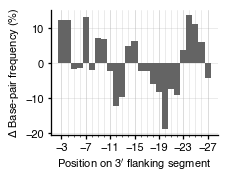

In [628]:
fig, ax = plt.subplots(1, 1, figsize=(3,2.3))
ax.bar(xs,ys,color='#646464',width=1,zorder=2)
ax.set_ylabel('$\Delta$ Base-pair frequency (%)')
ax.set_xlabel('Position on 3$^\prime$ flanking segment')
ax.set_xticks(-np.arange(3,28,4))
ax.set_xticks(-np.arange(3,28),minor=True)
ax.invert_xaxis()
ax.grid(which='both',ls='-',lw=.5)
#fig.savefig(resultpath + '201119_f6e__structure.pdf')

In [588]:
rcutoff = 20
ncancer = 10
nmirs = 200

In [330]:
tcgapath = 'supplementary/TCGA'
cancers = [ fo for fo in listdir(tcgapath) if not fo.startswith('.') ]
print len(cancers)

32


In [331]:
exptbls = {}
for cancer in cancers:
    fname = [ f for f in listdir('%s/%s'%(tcgapath,cancer)) if f.endswith('uq') ][0]
    tbl = pd.read_table('%s/%s/%s'%(tcgapath, cancer, fname), index_col=0)
    tbl.index = [ i.split('|')[0] for i in tbl.index ]
    exptbls[cancer] = tbl

In [416]:
def get_corrs(protein, rcutoff):
    tblr, tblp = pd.DataFrame(), pd.DataFrame()
    for cancer in cancers:
        exps = exptbls[cancer]
        if protein not in exps.index:
            continue
        mats = [ m for m in exps.index if m.startswith('hsa-') and ' ' not in m ]
        robust = sorted(mats, key=lambda x: np.average(exps.loc[x]))[-nmirs:]
        for m in robust:
            r, p = spearmanr(exps.loc[protein], exps.loc[m])
            tblr.loc[m, cancer] = r
            tblp.loc[m, cancer] = p
    return tblr, tblp

In [589]:
tr = get_corrs('SFRS3', rcutoff)[0]

In [590]:
corrtbl = tr[tr.apply(lambda x: len(x.dropna())>=1, axis=1)]
#tr2['average'] = tr2.apply(lambda x: sem(x.dropna()[:-1]), axis=1)
#tr2['sem'] = tr2.apply(lambda x: sem(x.dropna()[:-1]), axis=1)
#corrtbl = tr2.sort_values('average')

In [354]:
from scipy.stats import spearmanr, pearsonr, mannwhitneyu

In [513]:
def find_cnnc_v2(mir):
    ps, pe = preposition[mir]
    seq = constseqs[mir][pe+15:pe+21].replace('T','U')
    return bool(re.search('C[A-Z][A-Z]C', seq))
    #return bool(re.search('CUAC|CAUC', seq))

In [550]:
dbtbl = pd.read_table('/casa/bsc/projects/resources/mirgenedb_190702/\
human_mirgenedb_browser.txt',index_col=0)
dbtbl.head(1)
namedic = dbtbl['MiRBase ID'].to_dict()
namedic['Hsa-Let-7-P1']

'hsa-let-7a-2'

In [558]:
guides = {}
for s in SeqIO.parse('../../2_Structure-of-pri/resources/mirgenedb_v2_guides.fa','fasta'):
    pri, guide = s.id.split('_')
    if pri not in namedic or namedic[pri]=='None':
        continue
    pri = namedic[pri]
    guides[pri] = guide
print len(guides), guides['hsa-let-7a-1']

527 5p


In [342]:
primat = get_pri_mature()

In [561]:
primat2 = {}
for pri in guides.keys():
    mats = primat[pri]
    if len(mats)==1:
        primat2[pri] = mats[0]
    else:
        for mat in mats:
            if mat.endswith(guides[pri]):
                primat2[pri] = mat
                continue
print primat2['hsa-let-7a-1']

hsa-let-7a-5p


In [583]:
cnncmirs = [ m for m in dboverlap if find_cnnc_v2(m) ]
nocnmirs = [ m for m in dboverlap if m not in cnncmirs ]
openmirs = [ m for m in dboverlap if strintra.loc[m,range(16,22)].sum()==0 ]
strtmirs = [ m for m in dboverlap if strintra.loc[m,range(16,22)].sum()>0 ]
print len(cnncmirs), len(nocnmirs), len(openmirs), len(strtmirs)

296 217 74 439


In [584]:
cnncmats = set([primat2[p] for p in cnncmirs if p in primat2])
nocnmats = set([primat2[p] for p in nocnmirs if p in primat2])
openmats = set([primat2[p] for p in openmirs if p in primat2])
strtmats = set([primat2[p] for p in strtmirs if p in primat2])
print len(cnncmats), len(nocnmats), len(openmats), len(strtmats)

252 196 73 379


In [585]:
cnncopen = cnncmats&openmats
cnncstrt = cnncmats&strtmats
nocnopen = nocnmats&openmats
nocnstrt = nocnmats&strtmats
print len(cnncopen), len(cnncstrt), len(nocnopen), len(nocnstrt)

48 215 26 172


In [594]:
def get_all_corrs(mat):
    if mat not in corrtbl.index:
        return []
    return corrtbl.loc[mat].dropna().tolist()

In [595]:
get_all_corrs('hsa-let-7a-5p')

[-0.263077629084369,
 -0.080041011619959,
 -0.2788732394366197,
 0.03678192031964255,
 -0.5527410107115871,
 0.058581962040411925,
 -0.40338313372021234,
 -0.12844008391953599,
 -0.12284804542575331,
 -0.27243478743478744,
 0.124561536030913,
 0.05035046973406147,
 0.050467212183763877,
 -0.257802799094471,
 -0.02116642958748222,
 -0.19046690046337011,
 -0.09389887570620373,
 -0.11646556024244305,
 0.03934480995743088,
 0.18122083533605704,
 -0.3693817199294667,
 0.06594301221166893,
 0.18074439591033456,
 0.08770116337672137,
 -0.18458771551788491,
 0.13196480938416422,
 -0.03492516037063437,
 -0.18933272757009323,
 -0.02426297849802236,
 0.28803088803088805,
 0.14790652385589095,
 -0.09431929181929181]

In [593]:
mirls = [ cnncmirs, nocnmirs ]
data = [ [corr for mat in matl for corr in get_all_corrs(mat)] for matl in matls ]
colors = [ '#67a9cf','#af8dc3' ]
labels = [ 'CNNC', 'No CNNC' ]

[1611, 132, 2417, 759]
1.356720316867712e-10
0.1435184367849967
0.07274145034416252


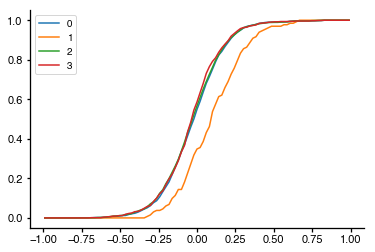

In [591]:
for mirl, label, color in zip(mirls,labels,colors):
    opens = [ primat2[m] for m in mirl if strintra.loc[m,range(16,22)].sum()==0 and
              m in primat2 ]
    pairs = [ primat2[m] for m in mirl if strintra.loc[m,range(16,22)].sum()==0 and
              m in primat2 ]
    dopen = [ corr for mat in opens for corr in get_all_corrs(mat) ]
    
    vs, ts = np.histogram(d,bins=np.linspace(-1,1,100))
    xs = (ts[1:]+ts[:-1])/2
    ys = vs.cumsum()/vs.sum()
    plt.plot(xs,ys,label=i)
plt.legend()

Text(18,70,u'SRSF3-\nbinding site')

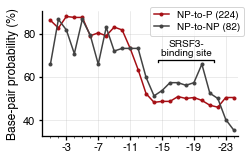

In [230]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,2.3))
ax.errorbar(xs,ys1,ms=3,marker='o',color='#a50f15',zorder=2,label='NP-to-P (%s)'%len(rescue))
ax.errorbar(xs,ys2,ms=3,marker='o',color='#424242',zorder=2,label='NP-to-NP (%s)'%len(nodcsdb))

ax.set_xlim(0,24.5)
ax.set_ylabel('Base-pair probability (%)',fontsize=12)
ax.set_xticks(range(3,25,4))
ax.set_xticks(range(1,25),minor=True)
ax.set_xticklabels([-3,-7,-11,-15,-19,-23])
ax.grid(ls='-',lw=.5)
ax.legend(handlelength=1.5, loc=(.55,.8), prop={'size':10}, labelspacing=.3)
ax.plot([14.5,14.5,21.5,21.5],[67,68,68,67],'k-',lw=1.3)
ax.text(18,70,'SRSF3-\nbinding site',ha='center',linespacing=.95)
#fig.savefig(resultpath + '201016_f5f__basepair_frequency_intra_hiseq.pdf')#,dpi=300)

# G. Primary sequence motifs of SRSF3-dependent miRNAs

In [227]:
def clv_to_relative_pos(mir, c5, c3):
    ps, pe, strand = s2.loc[mir, ['Start','End','Strand']]
    if strand=='+':
        return c5-ps+1, c3-ps+1
    return pe-c5+1, pe-c3+1

In [228]:
seq5tbl, seq3tbl = pd.DataFrame(columns=range(-20,30)), pd.DataFrame(columns=range(-25,30))
str5tbl, str3tbl = pd.DataFrame(columns=range(-20,30)), pd.DataFrame(columns=range(-25,30))

In [229]:
for mir in s8.index:
    if mir in dcsmirs:
        pres, pree = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
        rps, rpe = clv_to_relative_pos(mir, int(pres), int(pree))
    else:
        ps, pe = get_pre_annot(mir)[1:3]
        rps, rpe = mirbase_to_relative_pos(mir, ps, pe)
    priseq = constseqs[mir].replace('T','U')
    strt = [ 1 if s=='M' else 0 for s in s5.loc[mir,'symbolized structure'] ]
    seq5, str5 = priseq[max(0,rps-21):rps+29][::-1], strt[max(0,rps-21):rps+29][::-1]
    seq3, str3 = priseq[rpe-30:min(125,rpe+25)], strt[rpe-30:min(125,rpe+25)]
    pos5, pos3 = range(-20,30)[::-1], range(-25,30)[::-1]
    seq5tbl.loc[mir] = pd.Series(dict(zip(pos5,seq5)[::-1]))
    seq3tbl.loc[mir] = pd.Series(dict(zip(pos3,seq3)[::-1]))
    str5tbl.loc[mir] = pd.Series(dict(zip(pos5,str5)[::-1]))
    str3tbl.loc[mir] = pd.Series(dict(zip(pos3,str3)[::-1]))

In [230]:
seq5tbl = seq5tbl.fillna('')
str5tbl = str5tbl.fillna('')
seq3tbl = seq3tbl.fillna('')
str3tbl = str3tbl.fillna('')

In [231]:
def find_ug(mir, pos):
    seq = ''.join(seq5tbl.loc[mir,range(pos,pos+2)].fillna(''))
    return seq=='UG'

In [232]:
def find_ugu(mir, pos):
    seq = ''.join(seq5tbl.loc[mir,range(pos,pos+3)])
    return (seq=='UGU' or seq=='GUG')

In [233]:
def find_cnnc(mir, pos):
    seq = ''.join(seq3tbl.loc[mir,range(pos-3,pos+1)].fillna(''))
    return bool(re.search('C[A-Z][A-Z]C', seq))

In [234]:
def find_ghg(mir, pos):
    seq = ''.join(seq3tbl.loc[mir,range(pos-2,pos+1)].fillna(''))
    st = str3tbl.loc[mir,range(pos-2,pos+1)].tolist()
    return (bool(re.search('G[^G][A-Z]', seq)) and st==[1,0,1])
    #return (st==[1,0,1])

In [53]:
motifs = [ 'CNNC', 'UG', 'GHG', 'UGU' ]
ranges = { 'UG':range(-16,-11),'UGU':range(20,25),'GHG':range(-5,0), 'CNNC':range(-20,-15) }
funcs = { 'UG':find_ug, 'UGU':find_ugu, 'GHG':find_ghg, 'CNNC':find_cnnc }

In [54]:
bsfreq = defaultdict(lambda: defaultdict(int))
for mir in s8.index:
    for motif in motifs:
        for pos in ranges[motif]:
            bsfreq[motif][pos]+=int(funcs[motif](mir,pos))/len(s8.index)

In [55]:
mirls = [nptop, ptop]

In [56]:
entbls = defaultdict(lambda: pd.DataFrame())
for motif in motifs:
    for i, mirl in enumerate(mirls):
        for pos in ranges[motif]:
            freq = len([m for m in mirl if funcs[motif](m,pos)])/len(mirl)
            if freq==0:
                entbls[motif].loc[i,pos] = -1
            else:
                entbls[motif].loc[i,pos] = np.log2(freq/bsfreq[motif][pos])
                #entbls[motif].loc[i,pos] = np.log2(freq/np.average(bsfreq[motif].values()))

In [247]:
labels = [ 'NP-to-P', 'P-to-P' ]
arms = { 'UG':'5p', 'UGU':'5p', 'GHG':'3p', 'CNNC':'3p' }
cmap = custom_cmap(['#404040','#f0f0f0','#f0f0f0','#a50f15'], nspace=6)
emax, emin = 1.5, -1.5

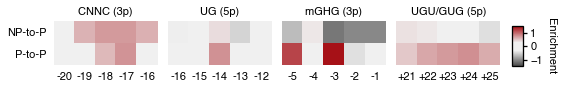

In [248]:
fig, axes = plt.subplots(1, 4, figsize=(8,.8), sharey=True)
for motif,ax in zip(motifs,axes):
    im = ax.pcolor(entbls[motif],cmap=cmap,vmax=emax,vmin=emin)
    ax.set_xticks(np.arange(5)+.5)
    ax.set_xticklabels([i if i<0 else '+%s'%(i+1) for i in ranges[motif]])
    ax.tick_params(left='off',bottom='off')
    ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
    ax.set_title('%s (%s)'%(motif.replace('UGU','UGU/GUG').replace('GHG','mGHG'),arms[motif]))
ax = axes[0]
ax.invert_yaxis()
ax.set_yticks(np.arange(len(mirls))+.5)
ax.set_yticklabels(labels, fontsize=11)
axcb = fig.add_axes([.92,.1,.02,.7])
cb = plt.colorbar(im, cax=axcb); cb.set_ticks([-1,0,1])
fig.text(.98,.45,'Enrichment',va='center',rotation=270,fontsize=11)
fig.subplots_adjust(wspace=.1)
fig.savefig(resultpath + '201016_f5g__nptop_ptop_sequence_hiseq_v1.pdf')#,dpi=300)

# H. Comparison with DROSHA fCLIP-seq sites

In [249]:
s6sort = s6.sort_values('Cleavage Specificity', ascending=False)
shifted = []
for mir in ptop:
    c5 = int(s7.loc[mir,"IVP 5' site"].split(', ')[0])
    c3 = int(s7.loc[mir,"IVP 3' site"].split(', ')[0])
    c5new, c3new = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
    if c5!=int(c5new) or c3!=int(c3new):
        shifted.append(mir)
print len(shifted)

50


In [261]:
consis, incons = [],[]
for mir in shifted:
    if mir not in s7["fCLIP 5' site"].dropna().index: continue
    fcl5cs = map(int, s7.loc[mir,"fCLIP 5' site"].split(', '))
    fcl3cs = map(int, s7.loc[mir,"fCLIP 3' site"].split(', '))
    c5new, c3new = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
    if int(c5new) in fcl5cs and int(c3new) in fcl3cs:
        consis.append(mir)
    else:
        incons.append(mir)
print len(consis), len(incons)

18 1


In [262]:
data = [ len(consis), len(incons) ]
frac = map(lambda x:x/sum(data)*100, data)
colors = [ '#8da0cb', '#969696' ]
title = 'P-to-P miRNAs with altered cleavage sites (n=%s)'%sum(data)
labels = ['Matched with fCLIP site','Not matched']

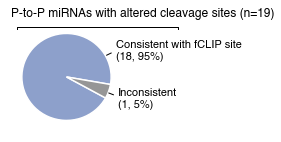

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))

ps, ts = ax.pie(data,colors=colors,startangle=-10,textprops={'fontsize':12},)
for p in ps:
    p.set_linewidth(1.5)
    p.set_edgecolor('white')

ax.text(1.1,.4,'Consistent with fCLIP site\n(%s, %.0f%%)'%(data[0],frac[0]),fontsize=11)
ax.text(1.15,-.7,'Inconsistent\n(%s, %.0f%%)'%(data[1],frac[1]),fontsize=11)

l = lines.Line2D([.9,1],[.5,.55],color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
l = lines.Line2D([.95,1.05],[-.37,-.41],color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
l = lines.Line2D([-1.1,-1.1,2.5,2.5],[1.1,1.15,1.15,1.1],
                color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
ax.text(-1.25,1.4,title,fontsize=12)
fig.savefig(resultpath + '201016_f5h__comparison_fCLIP_hiseq.pdf')#,dpi=300)

In [264]:
fclipexcel = pd.ExcelFile('supplementary/Kim_2017_s2.xlsx')
fclip293t = fclipexcel.parse('HEK293T_miRBase', index_col=0)
fcliphela = fclipexcel.parse('HeLa_miRBase', index_col=0)
both293t = fclip293t[(fclip293t['Group5p']!='Unidentified')
                     &(fclip293t['Group3p']!='Unidentified')]
bothhela = fcliphela[(fcliphela['Group5p']!='Unidentified')
                     &(fcliphela['Group3p']!='Unidentified')]

In [265]:
consis, incons = [],[]
for mir in nptop:
    if mir in both293t.index:
        fcl5cs = map(int, str(both293t.loc[mir, 'fCLIPPosition5p']).split(';'))
        fcl3cs = map(int, str(both293t.loc[mir, 'fCLIPPosition3p']).split(';'))
    elif mir in bothhela.index:
        fcl5cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition5p']).split(';'))
        fcl3cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition3p']).split(';'))
    else:
        continue
    c5new, c3new = s8.loc[mir,["5' cleavage site","3' cleavage site"]].astype(float)
    if int(c5new) in fcl5cs and int(c3new) in fcl3cs:
        consis.append(mir)
    else:
        incons.append(mir)
print len(consis), len(incons)

38 10


In [266]:
data = [ len(consis), len(incons) ]
frac = map(lambda x:x/sum(data)*100, data)
colors = [ '#66c2a5', '#969696' ]
title = 'NP-to-P miRNAs (n=%s)'%sum(data)
labels = ['Matched with fCLIP site','Not matched']

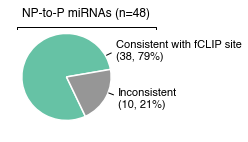

In [269]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))

ps, ts = ax.pie(data,colors=colors,startangle=10,textprops={'fontsize':12},)
for p in ps:
    p.set_linewidth(1.5)
    p.set_edgecolor('white')

ax.text(1.1,.4,'Consistent with fCLIP site\n(%s, %.0f%%)'%(data[0],frac[0]),fontsize=11)
ax.text(1.15,-.7,'Inconsistent\n(%s, %.0f%%)'%(data[1],frac[1]),fontsize=11)

l = lines.Line2D([.9,1],[.5,.55],color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
l = lines.Line2D([.95,1.05],[-.37,-.41],color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
l = lines.Line2D([-1.1,-1.1,2,2],[1.1,1.15,1.15,1.1],
                color='k',lw=1); ax.add_line(l); l.set_clip_on(False)
ax.text(-1,1.4,title,fontsize=12)
fig.savefig(resultpath + '201016_f5h_comparison_fCLIP_nptop_hiseq.pdf')#,dpi=300)